In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt

import prfpy
from scipy.io import loadmat
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

In [4]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

cf


In [52]:
import cortex.polyutils


subject = 'hcp_999999'

# First we need to import the surfaces for this subject
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "inflated")]

In [53]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

V1_mask = np.concatenate([maskL,maskR])

In [5]:
V1_mask

array([False, False, False, ..., False, False, False])

In [54]:
def psc(data):
  
  # crudely checking whether psc hasn't already happened, in which case do nothing
    if np.mean(data) < 0.5:
        return data
    return ((data.T/np.median(data, 1)).T - 1) * 100

import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])

def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def split_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

#     data = np.concatenate([l, r])
    return l, r



In [35]:
s1_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s1_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")
s2_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s2_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")

In [24]:
get_cortex(s1_f)[V1_mask].shape

(2890, 120)

In [5]:
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import matplotlib.animation as animation

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

new_dms.shape

(120, 100, 100)

In [60]:
prfparams = np.load("/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/gaussian-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy")

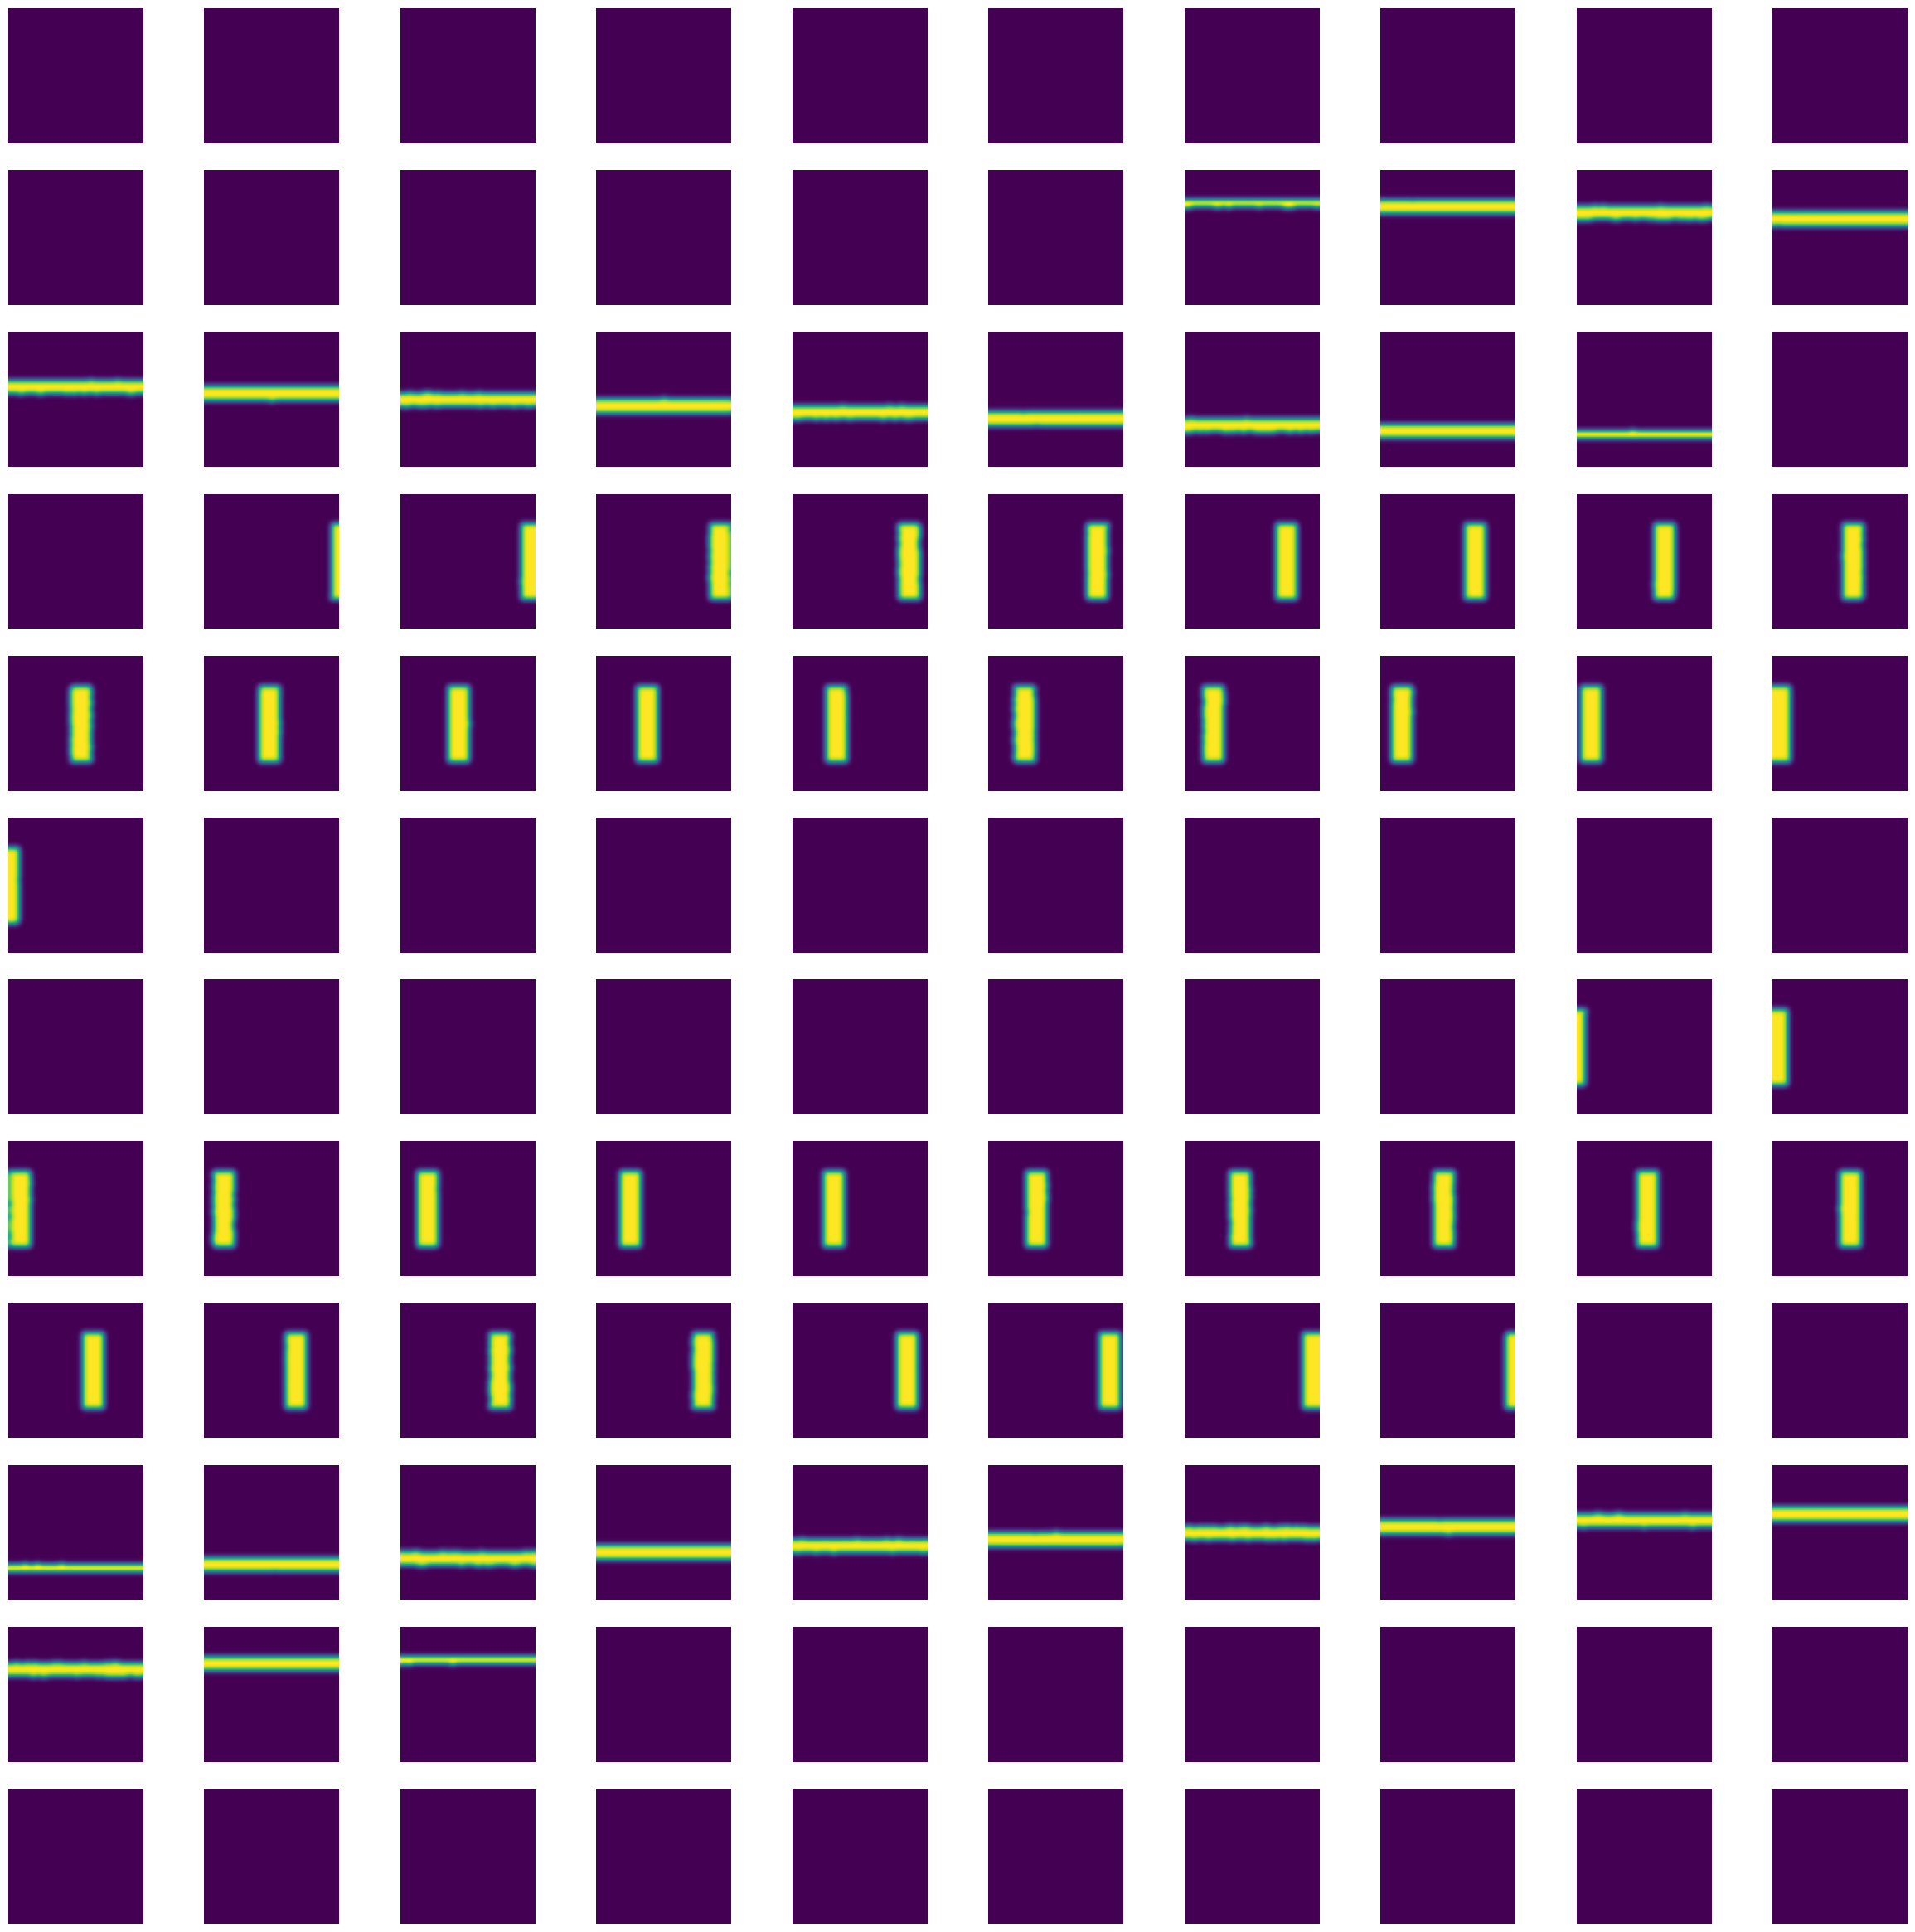

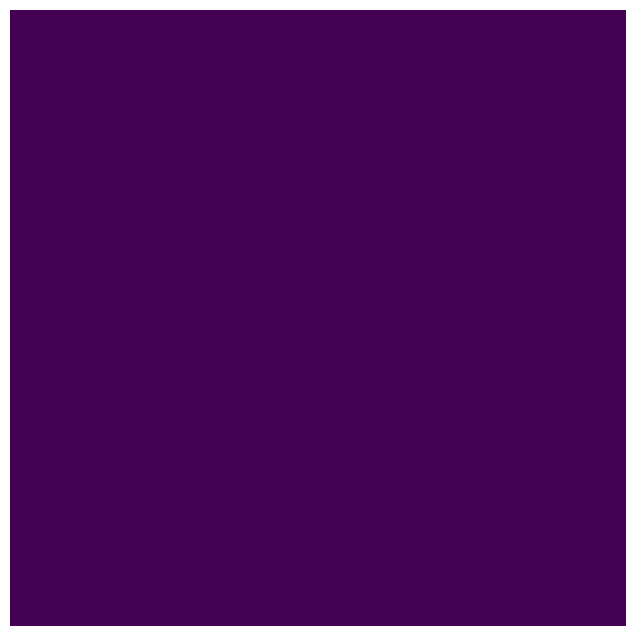

In [6]:
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import matplotlib.animation as animation

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

# But what does it look like? Let's plot the design we're using!
# we could do this by creating a whole sequence of imshow plots,
# but this turns ugly pretty quickly. 

f, ss = plt.subplots(12,10, figsize=(30,30))
shp = 0
for i in range(12):
    for j in range(10):
        ss[i,j].imshow(new_dms[shp])
        ss[i,j].axis('off')
        shp += 1

# perhaps it's best to try to visualize this as it was in the actual experiment.
# but Google Colab doesn't do interactive plots....

f, ax = plt.subplots(1, 1, figsize=(8,8))
ax.axis('off')
ims = []
for i in range(new_dms.shape[0]):
    if i == 0:
        ax.imshow(new_dms[i])  # show an initial one first
    im = ax.imshow(new_dms[i], animated=True)
    ims.append([im])

# ani = animation.ArtistAnimation(f, ims, interval=50, blit=True,
#                                 repeat_delay=1000)

# ani
# ani.save('/tank/klundert/projects/cfdn/notebooks/exp.mp4')
# by plotting the total amount of stimulus pixels on the screen over time
# we get a handle on the structure of the experiment

# sos = new_dms.sum((1,2))
# plt.figure()
# plt.plot(sos)
# plt.xlabel('time in TRs')
# plt.ylabel('total amount of stimulus pixels on the screen');

In [7]:
prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=210, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.4, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to set up parameter bounds in iterfit
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

sizes

array([1.51397155, 1.7624558 , 2.02981228, 2.31604097, 2.62114189,
       2.94511502, 3.28796038, 3.64967796, 4.03026776, 4.42972979,
       4.84806403, 5.2852705 , 5.74134919, 6.2163001 , 6.71012323,
       7.22281858, 7.75438616, 8.30482595, 8.87413797, 9.46232221])

In [88]:
simpsons = plt.imread('/tank/klundert/projects/cfdn/notebooks/simps.png', format='png')

In [17]:
np.save('/tank/klundert/projects/cfdn/data/CF_fit_utils/dm', new_dms)

In [18]:
new_dms.shape

(120, 100, 100)

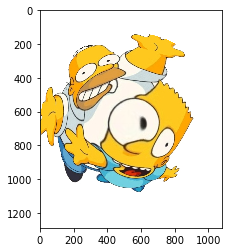

In [91]:
plt.imshow(simpsons)

In [9]:
def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

(-0.5, 99.5, 99.5, -0.5)

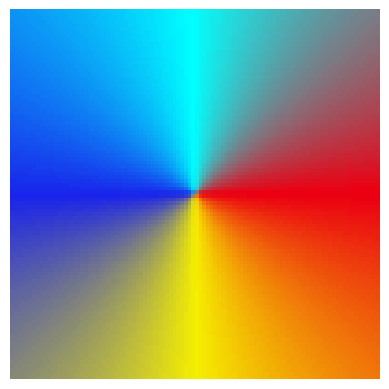

In [10]:
plt.imshow(angle(-prf_stim.x_coordinates, -prf_stim.y_coordinates), cmap=cx.utils.get_cmap('Retinotopy_RYBCR'))
plt.axis('off')

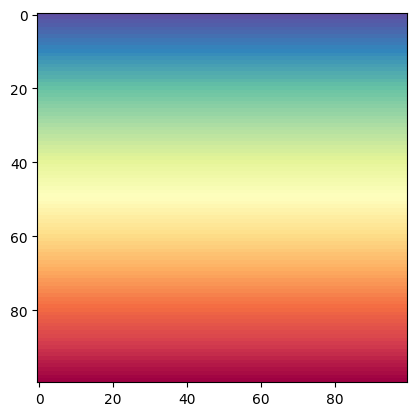

In [11]:
plt.imshow(prf_stim.polar_coordinates, cmap=cx.utils.get_cmap('Retinotopy_RYBCR'))
# plt.imshow(prf_stim.ecc_coordinates, cmap=cx.utils.get_cmap('inferno'))
plt.imshow(prf_stim.y_coordinates, cmap=cx.utils.get_cmap('spectral_r'))


In [110]:
from matplotlib.colors import ListedColormap
colormap_r = ListedColormap(cx.utils.get_cmap('Retinotopy_RYBCR').colors[::-1])

# cx.utils.get_cmap('Retinotopy_RYBCR').colors[::-1]

/tmp/ipykernel_1699466/1370828139.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap


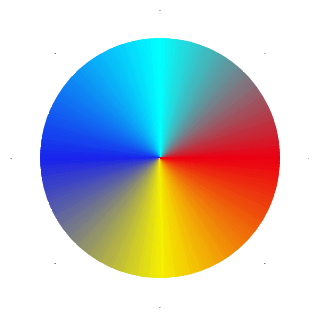

In [111]:
import matplotlib
fg = plt.figure(figsize=(3,3))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')

# Define colormap normalization for 0 to 2*pi
norm = matplotlib.colors.Normalize(0, 2*np.pi) 

n = 200  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(0,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap
ax.set_yticklabels([])                   #turn of radial tick labels (yticks)

ax.tick_params(pad=10,labelsize=0)      #cosmetic changes to tick labels
ax.spines['polar'].set_visible(False)    #turn off the axis spine.

In [16]:
def get_blend(Vertex, threshold=0, brightness=0.6,
                    contrast=0.25, smooth=20):
    """Blend the data with a curvature map depending on a transparency map.

    Vertex objects cannot use transparency as Volume objects. This method
    is a hack to mimic the transparency of Volume objects, blending the
    Vertex data with a curvature map. This method returns a VertexRGB
    object, and the colormap parameters (vmin, vmax, cmap, ...) of the
    original Vertex object cannot be changed later on.
    Parameters
    ----------
    Vertex : Vertex you want to plot
        Vertex you want to plot.
    alpha : array of shape (n_vertices, )
        Transparency map.
    threshold : float
        Threshold for the curvature map.
    brightness : float
        Brightness of the curvature map.
    contrast : float
        Contrast of the curvature map.
    smooth : float
        Smoothness of the curvature map.

    Returns
    -------
    blended : VertexRGB object
        The original map blended with a curvature map.
    """
    
    alpha = (~np.isnan(Vertex.data)).astype("float")

    curvature = cx.db.get_surfinfo('hcp_999999').data
    curvature = (curvature > 0).astype("float")
    curvature = curvature * contrast + brightness
    curvature_raw = cx.Vertex(curvature, subject='hcp_999999', vmin=0, vmax=1, cmap='gray').raw
    alpha = np.clip(alpha, 0, 1)  
    blended = deepcopy(Vertex.raw)  # copy because VertexRGB.raw returns self
    blended.red.data = blended.red.data * alpha + (1 - alpha) * curvature_raw.red.data
    blended.green.data = blended.green.data * alpha + (1 - alpha) * curvature_raw.green.data
    blended.blue.data = blended.blue.data * alpha + (1 - alpha) * curvature_raw.blue.data
    blended.red.data = blended.red.data.astype("uint8")
    blended.green.data = blended.green.data.astype("uint8")
    blended.blue.data = blended.blue.data.astype("uint8")

    
    return blended

In [15]:
surround_amplitude_grid=np.array([0.2,0.4,0.7,1,3,0.05], dtype='float32')
surround_size_grid=np.array([3,5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

In [16]:
gauss_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (0, 1000),  # prf amplitude
                (0, 0)]  # bold baseline



norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (0, 1000),  # prf amplitude
                (0, 0),  # bold baseline
                (0, 1000),  # surround amplitude
                (eps, 3*ss),  # surround size
                (0, 1000),  # neural baseline
                (1e-6, 1000)]  # surround baseline


# CF_bounds = [(0.1, 45),  # sigmas
#                 (0, 1000),  # beta
#                 (0, 0.0001), # baseline
#                 (0, 0)] # vert


# DNCF_bounds = [(0.1, 50),  # sigmas
#                 (0, 1000),  # prf amplitude
#                 (0, 0.0001), # baseline (A)
#                 (0, 0), # vert
#                 (0, 1000), # srf amplitude (C)
#                 (0.3, 100), # surround sigma 
#                 (0, 1000), # neural baseline (B)
#                 (1e-6, 1000)] # surround baseline (D)

In [55]:
dnparams = np.load('/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/dn-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy')
dnparams2 = np.load('/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/dn-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_norm_params_cv_fold1.npy')

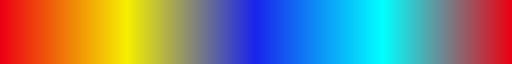

In [80]:
cx.utils.get_cmap('Retinotopy_RYBCR')

In [106]:
max_ecc_size

9.462322208025617

/tmp/ipykernel_1699466/2799340893.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap


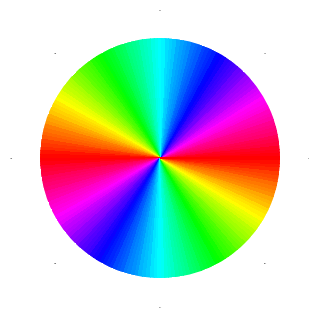

In [105]:
import matplotlib
from matplotlib.colors import ListedColormap
colormap_r = ListedColormap(cx.get_cmap('Retinotopy_HSV_2x_alpha').colors[0,:,:][::-1])
fg = plt.figure(figsize=(3,3))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')

# Define colormap normalization for 0 to 2*pi
norm = matplotlib.colors.Normalize(0, 2*np.pi) 

n = 200  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(0,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap
ax.set_yticklabels([])                   #turn of radial tick labels (yticks)

ax.tick_params(pad=10,labelsize=0)      #cosmetic changes to tick labels
ax.spines['polar'].set_visible(False)    #turn off the axis spine.

/tmp/ipykernel_1699466/3336454515.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap


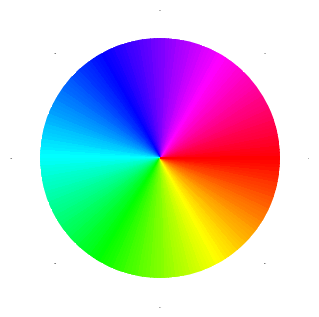

In [107]:
import matplotlib
from matplotlib.colors import ListedColormap
colormap_r = ListedColormap(cx.get_cmap('Retinotopy_HSV_alpha').colors[0,:,:][::-1])
fg = plt.figure(figsize=(3,3))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')

# Define colormap normalization for 0 to 2*pi
norm = matplotlib.colors.Normalize(0, 2*np.pi) 

n = 200  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(0,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap
ax.set_yticklabels([])                   #turn of radial tick labels (yticks)

ax.tick_params(pad=10,labelsize=0)      #cosmetic changes to tick labels
ax.spines['polar'].set_visible(False)    #turn off the axis spine.

/tmp/ipykernel_1696242/3076243219.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap


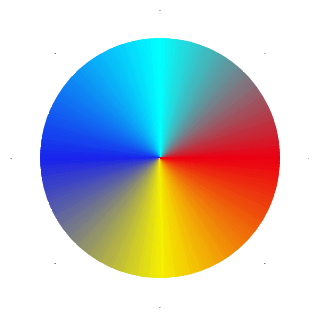

In [18]:
import matplotlib
from matplotlib.colors import ListedColormap
colormap_r = ListedColormap(cx.utils.get_cmap('Retinotopy_RYBCR').colors[::-1])
fg = plt.figure(figsize=(3,3))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')

# Define colormap normalization for 0 to 2*pi
norm = matplotlib.colors.Normalize(0, 2*np.pi) 

n = 200  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(0,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm, cmap=colormap_r)  #plot the colormesh on axis with colormap
ax.set_yticklabels([])                   #turn of radial tick labels (yticks)

ax.tick_params(pad=10,labelsize=0)      #cosmetic changes to tick labels
ax.spines['polar'].set_visible(False)    #turn off the axis spine.

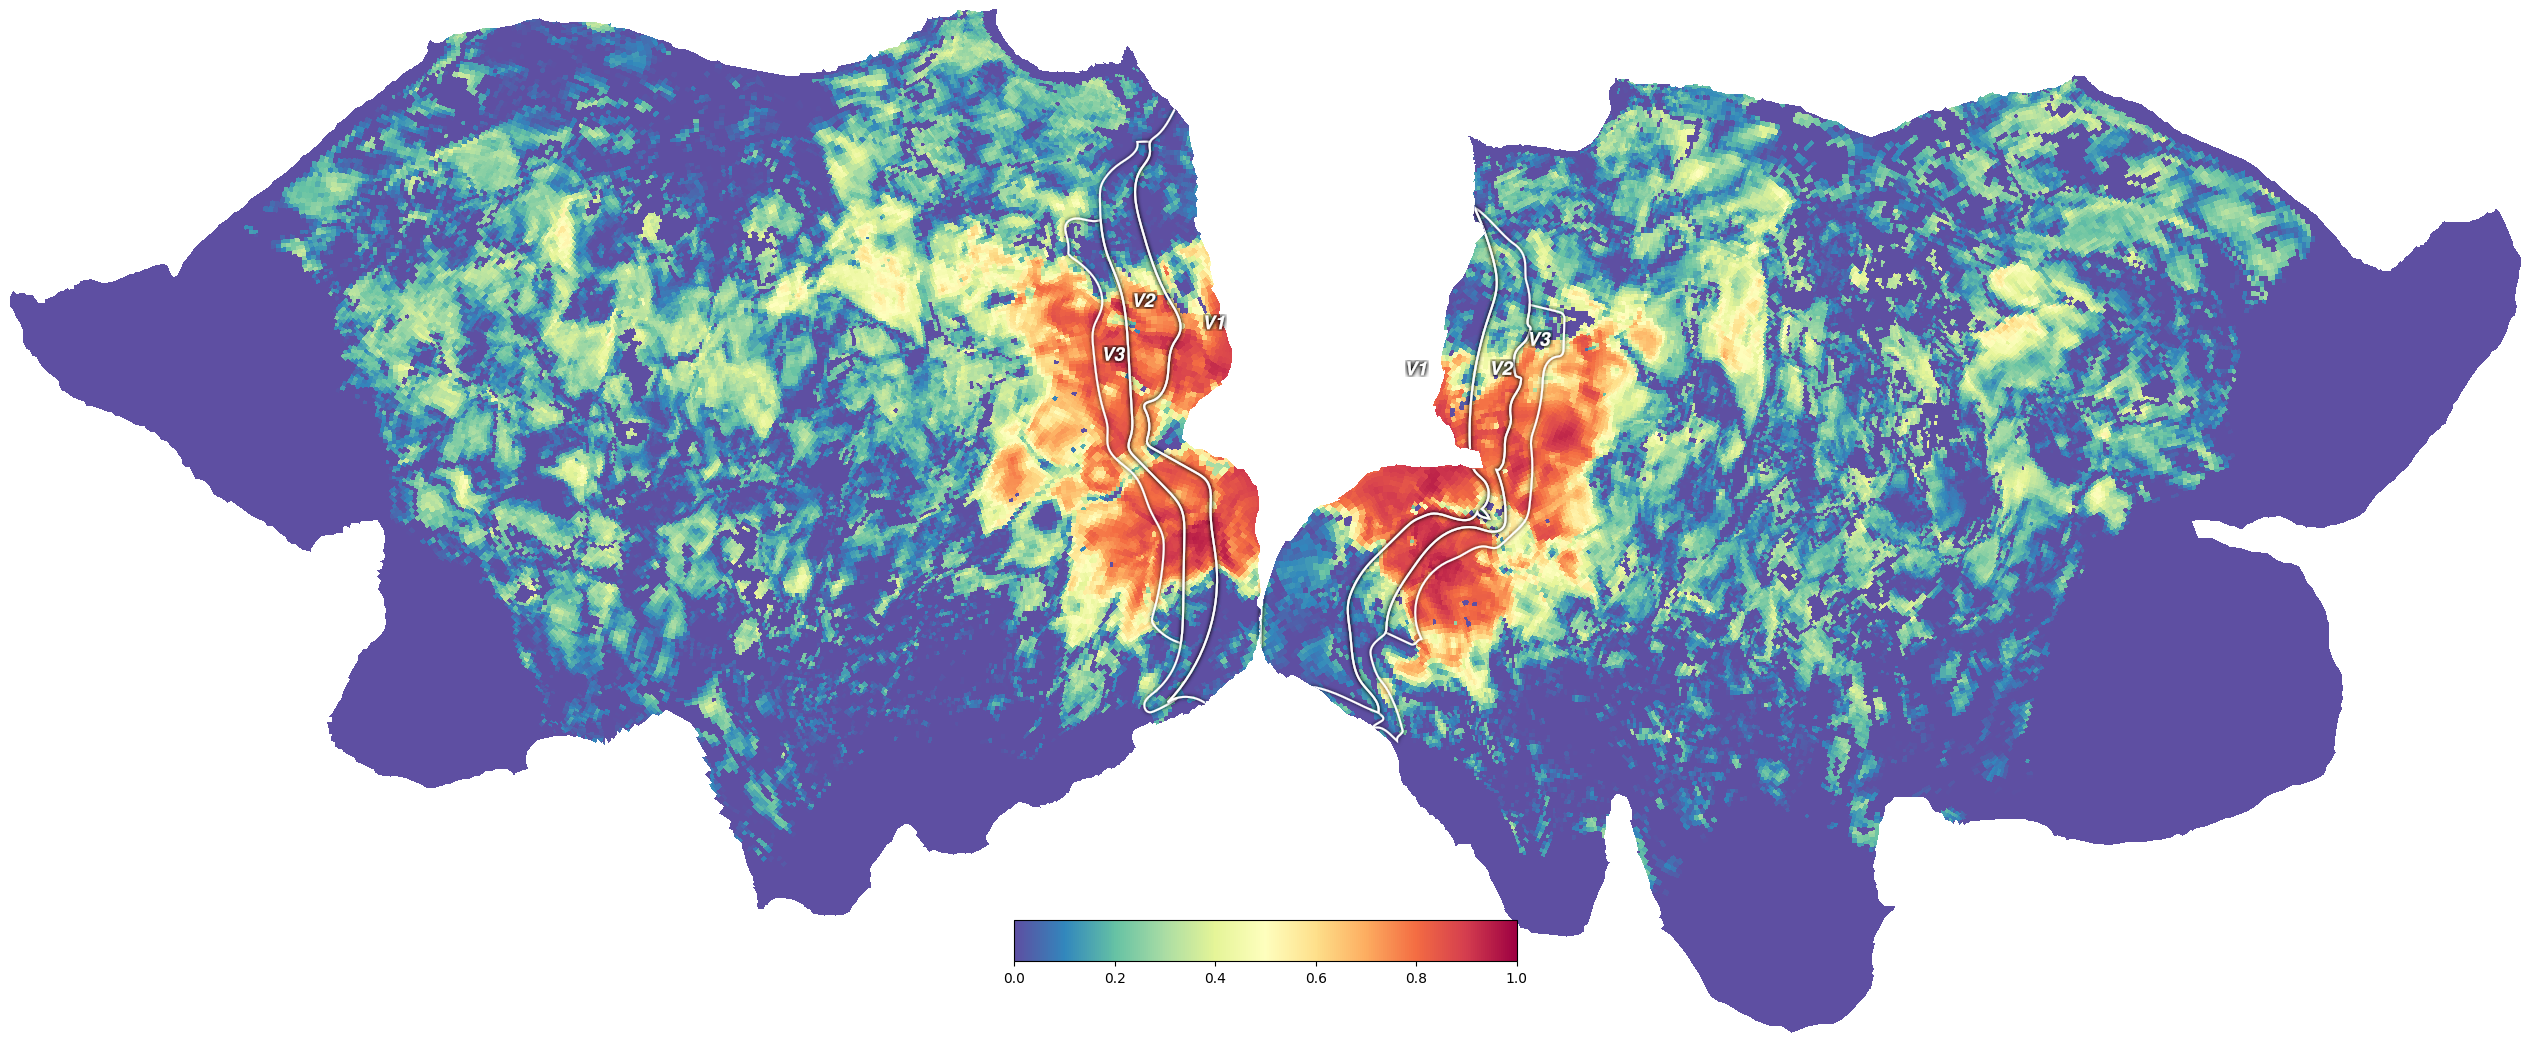

In [72]:
cx.quickshow(cx.Vertex(get_cortex(dnparams[:,-1]), subject='hcp_999999', cmap='spectral_r', vmin=0, vmax=1), with_curvature=True);

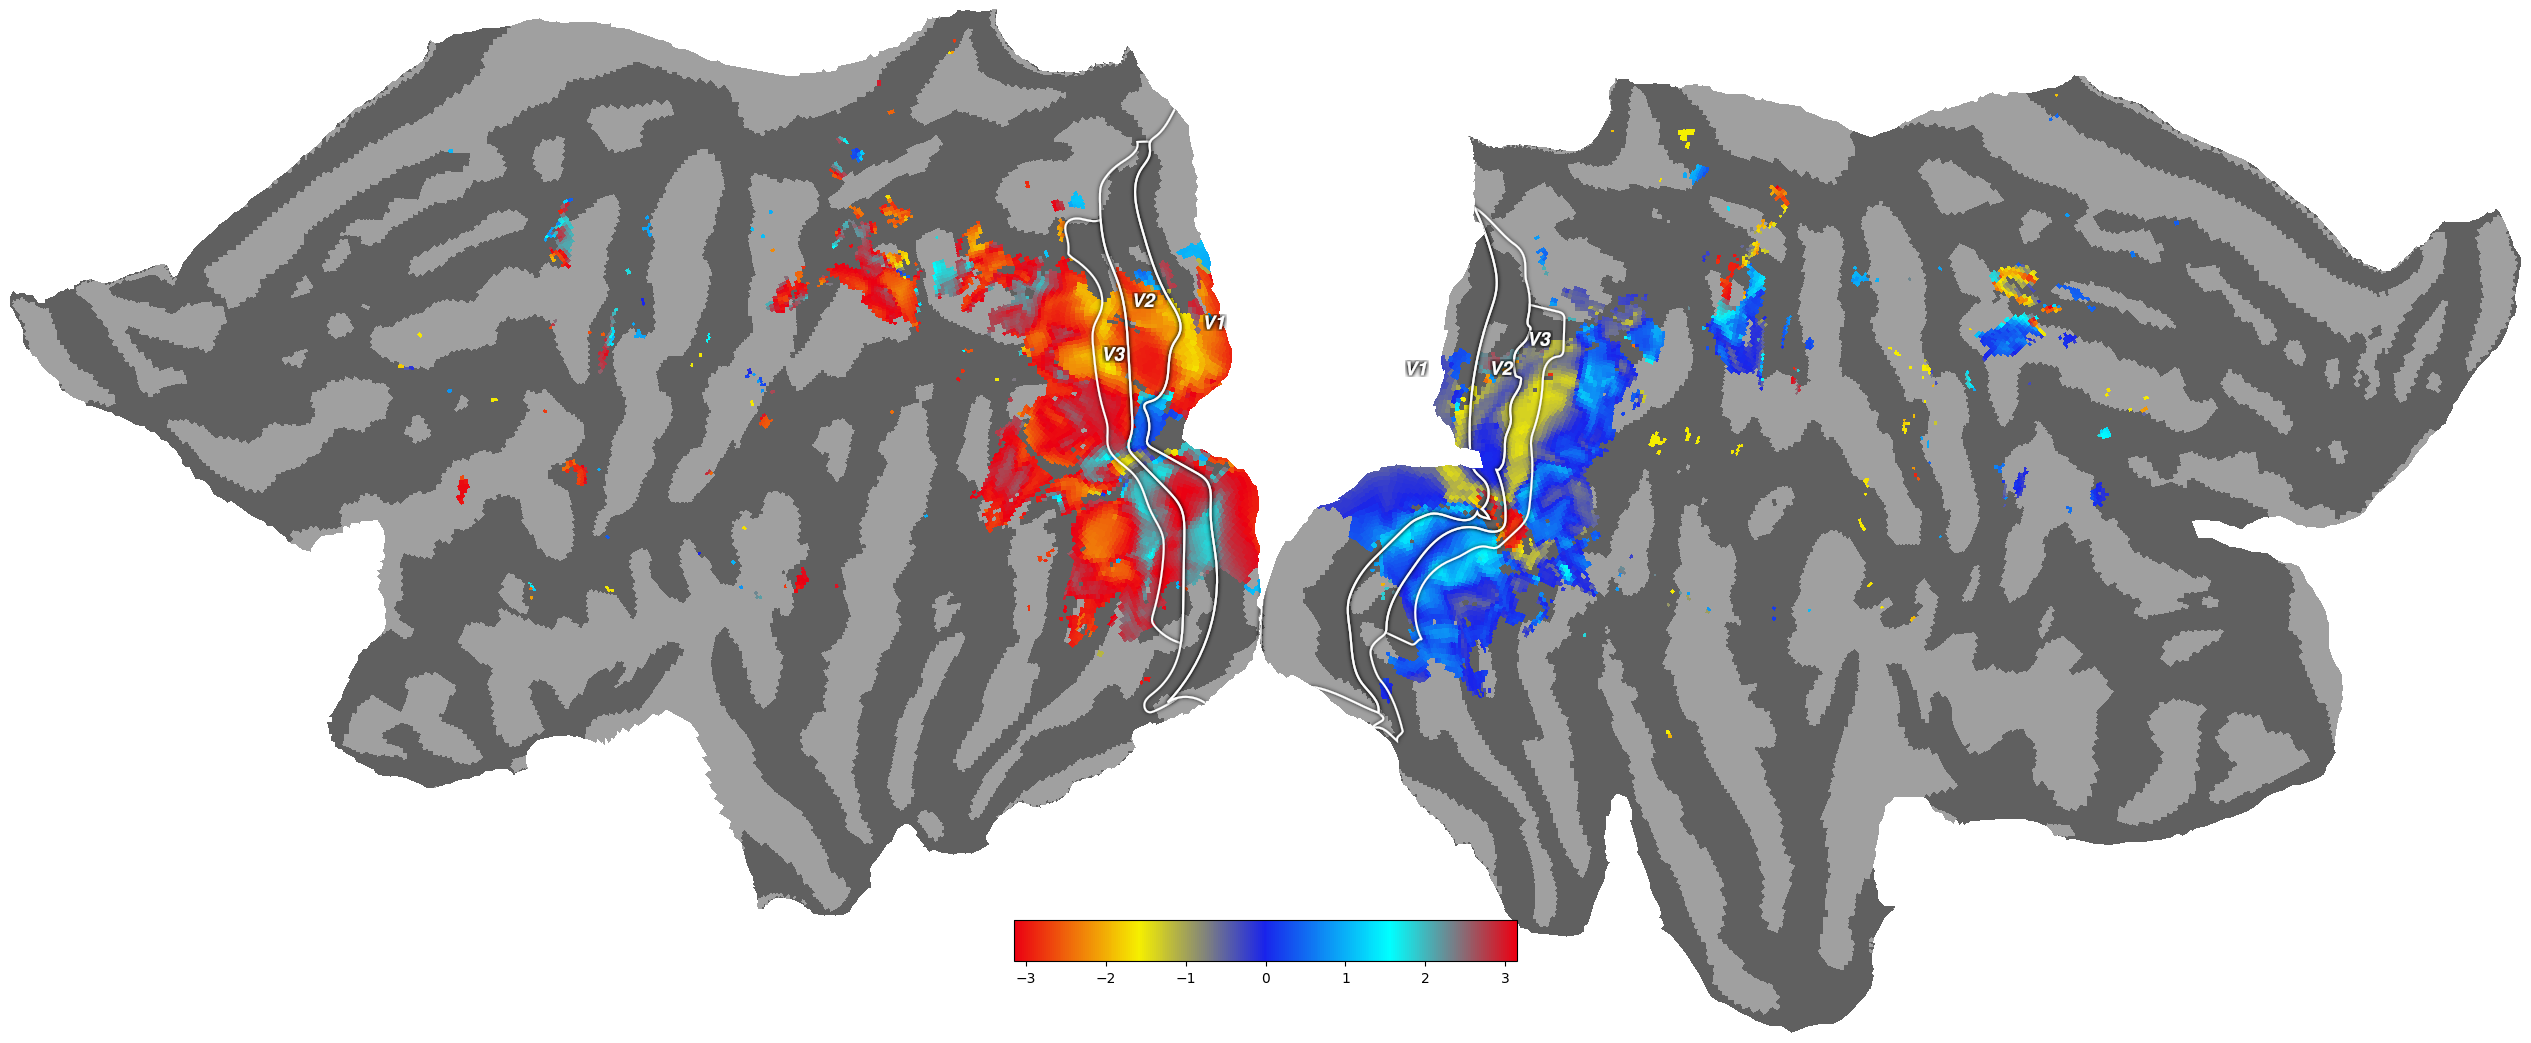

In [65]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[get_cortex(dnparams[:,-1]) > 0.40] = angle(get_cortex(dnparams[:,1]), get_cortex(dnparams[:,0])*-1)[get_cortex(dnparams[:,-1]) > 0.40]
s2angle = np.copy(toplot)

cx.quickshow(cx.Vertex(s2angle, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True);

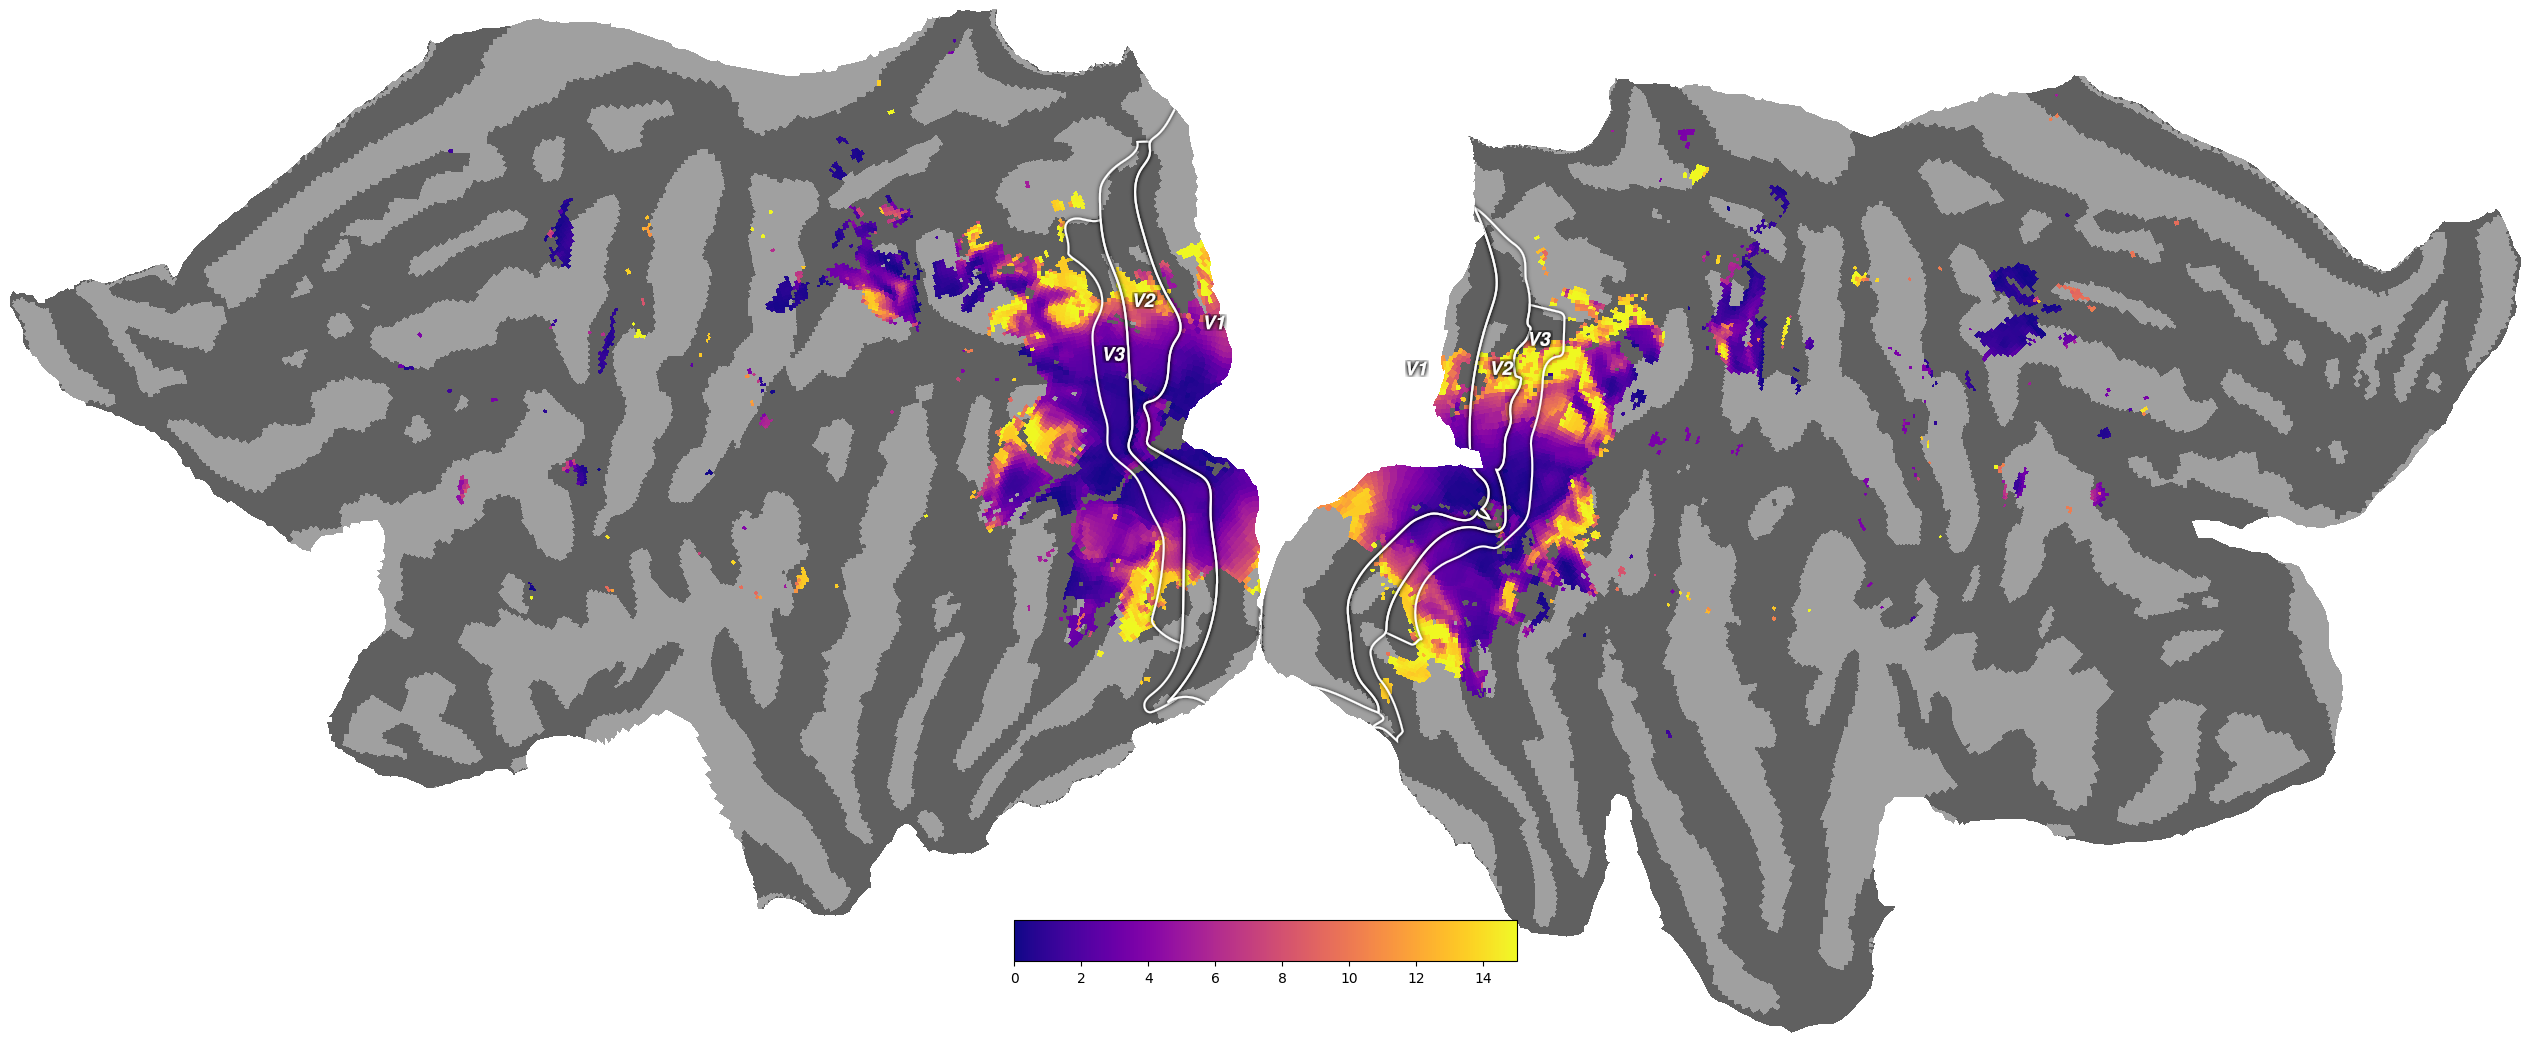

In [66]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[get_cortex(dnparams[:,-1]) > 0.4] = ecc(get_cortex(dnparams[:,1]), get_cortex(dnparams[:,0])*-1)[get_cortex(dnparams[:,-1]) > 0.4]
s2ecc = np.copy(toplot)


cx.quickshow(cx.Vertex(s2ecc, subject='hcp_999999', cmap='plasma', vmin=0, vmax=15), with_curvature=True);

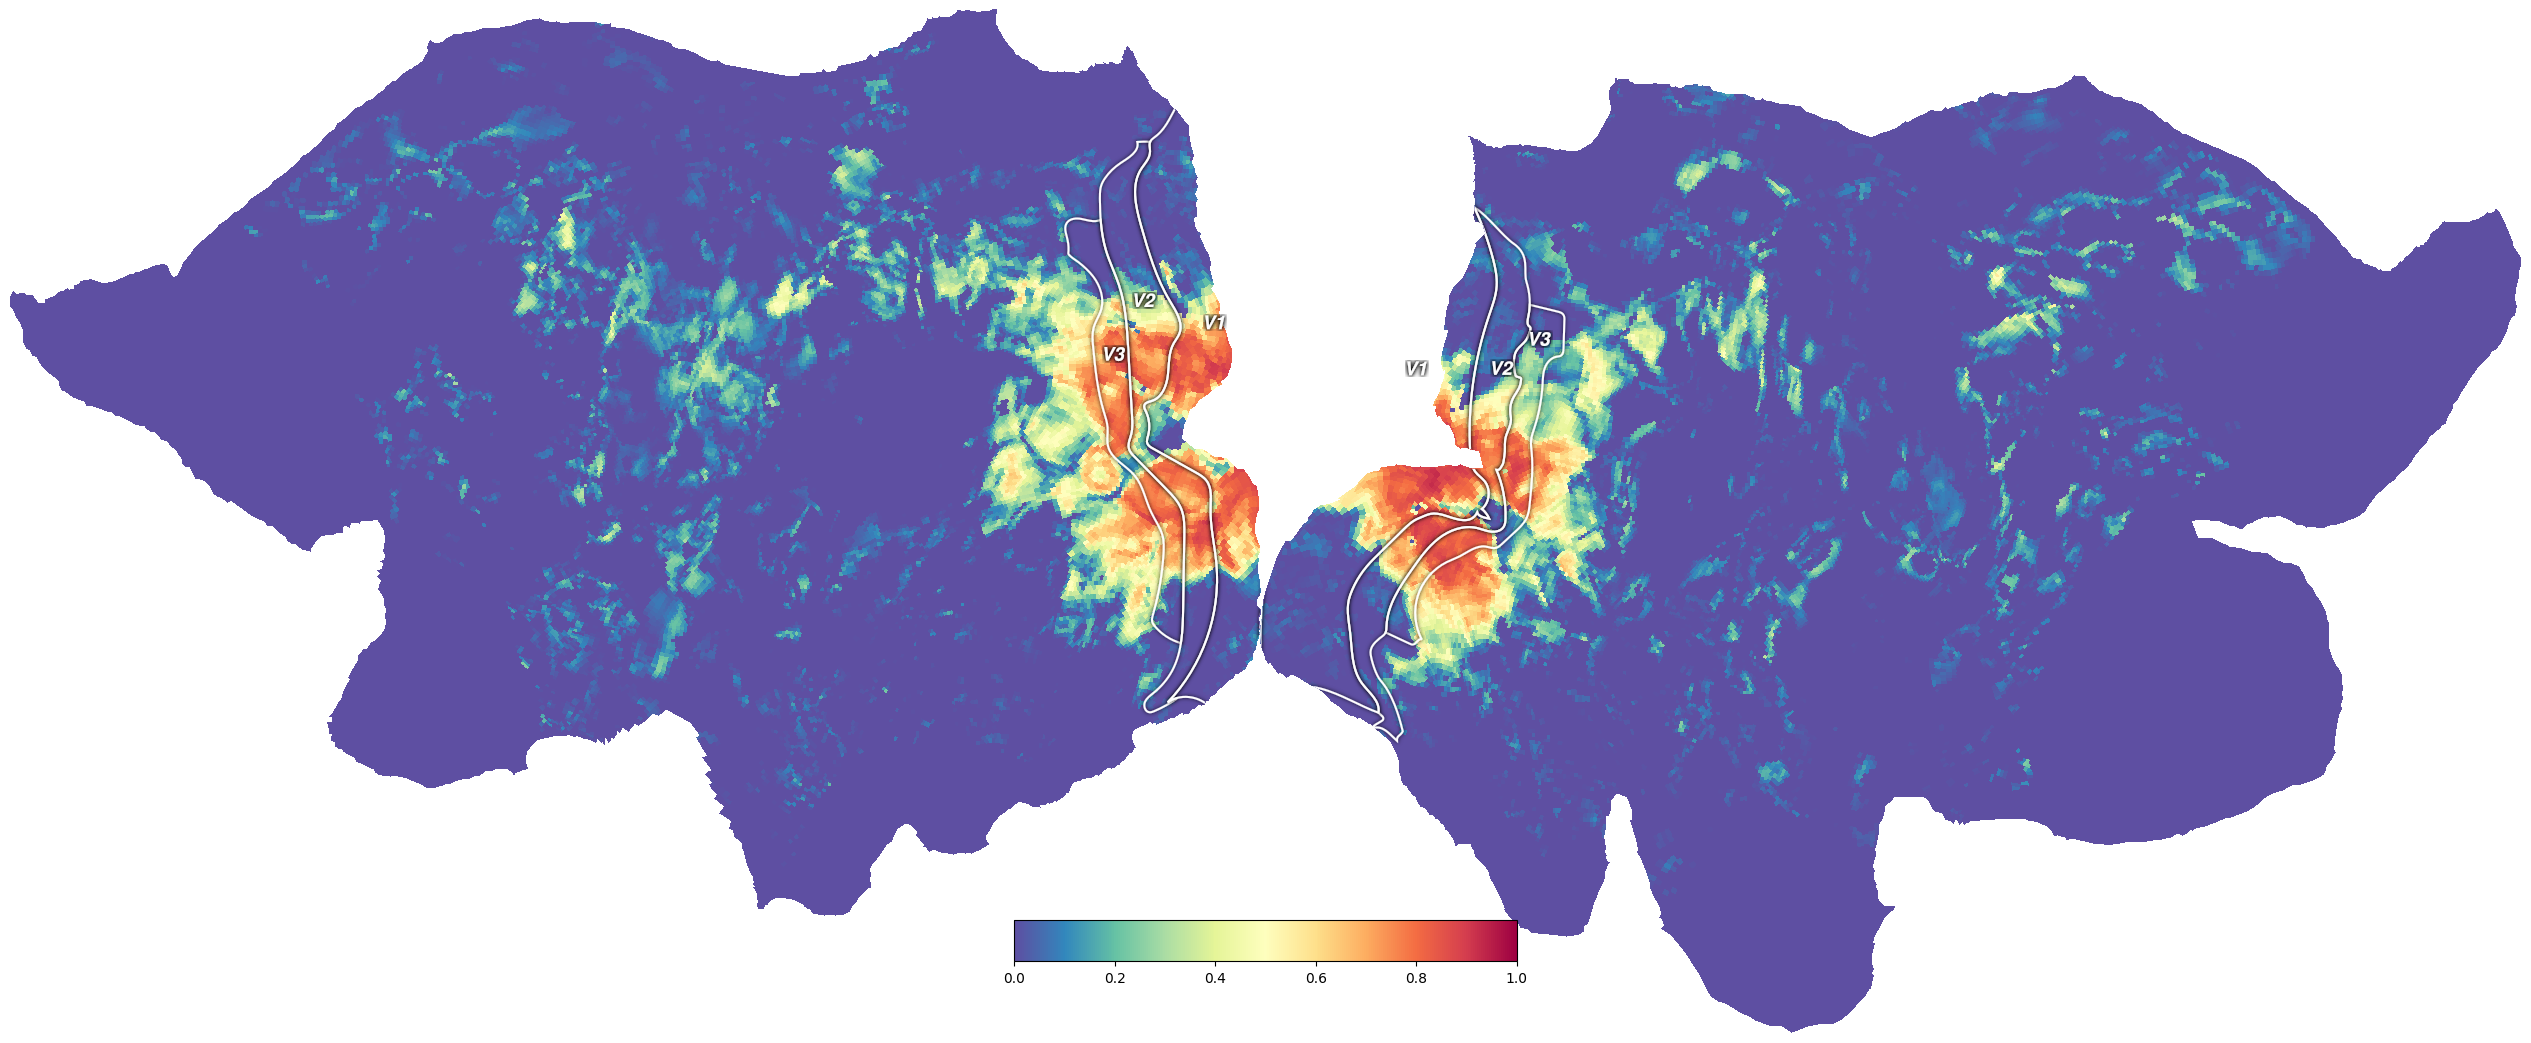

In [ ]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot = get_cortex(prfparams[:,-1])
# rsq = np.copy(toplot)


cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=0, vmax=1), with_curvature=True);

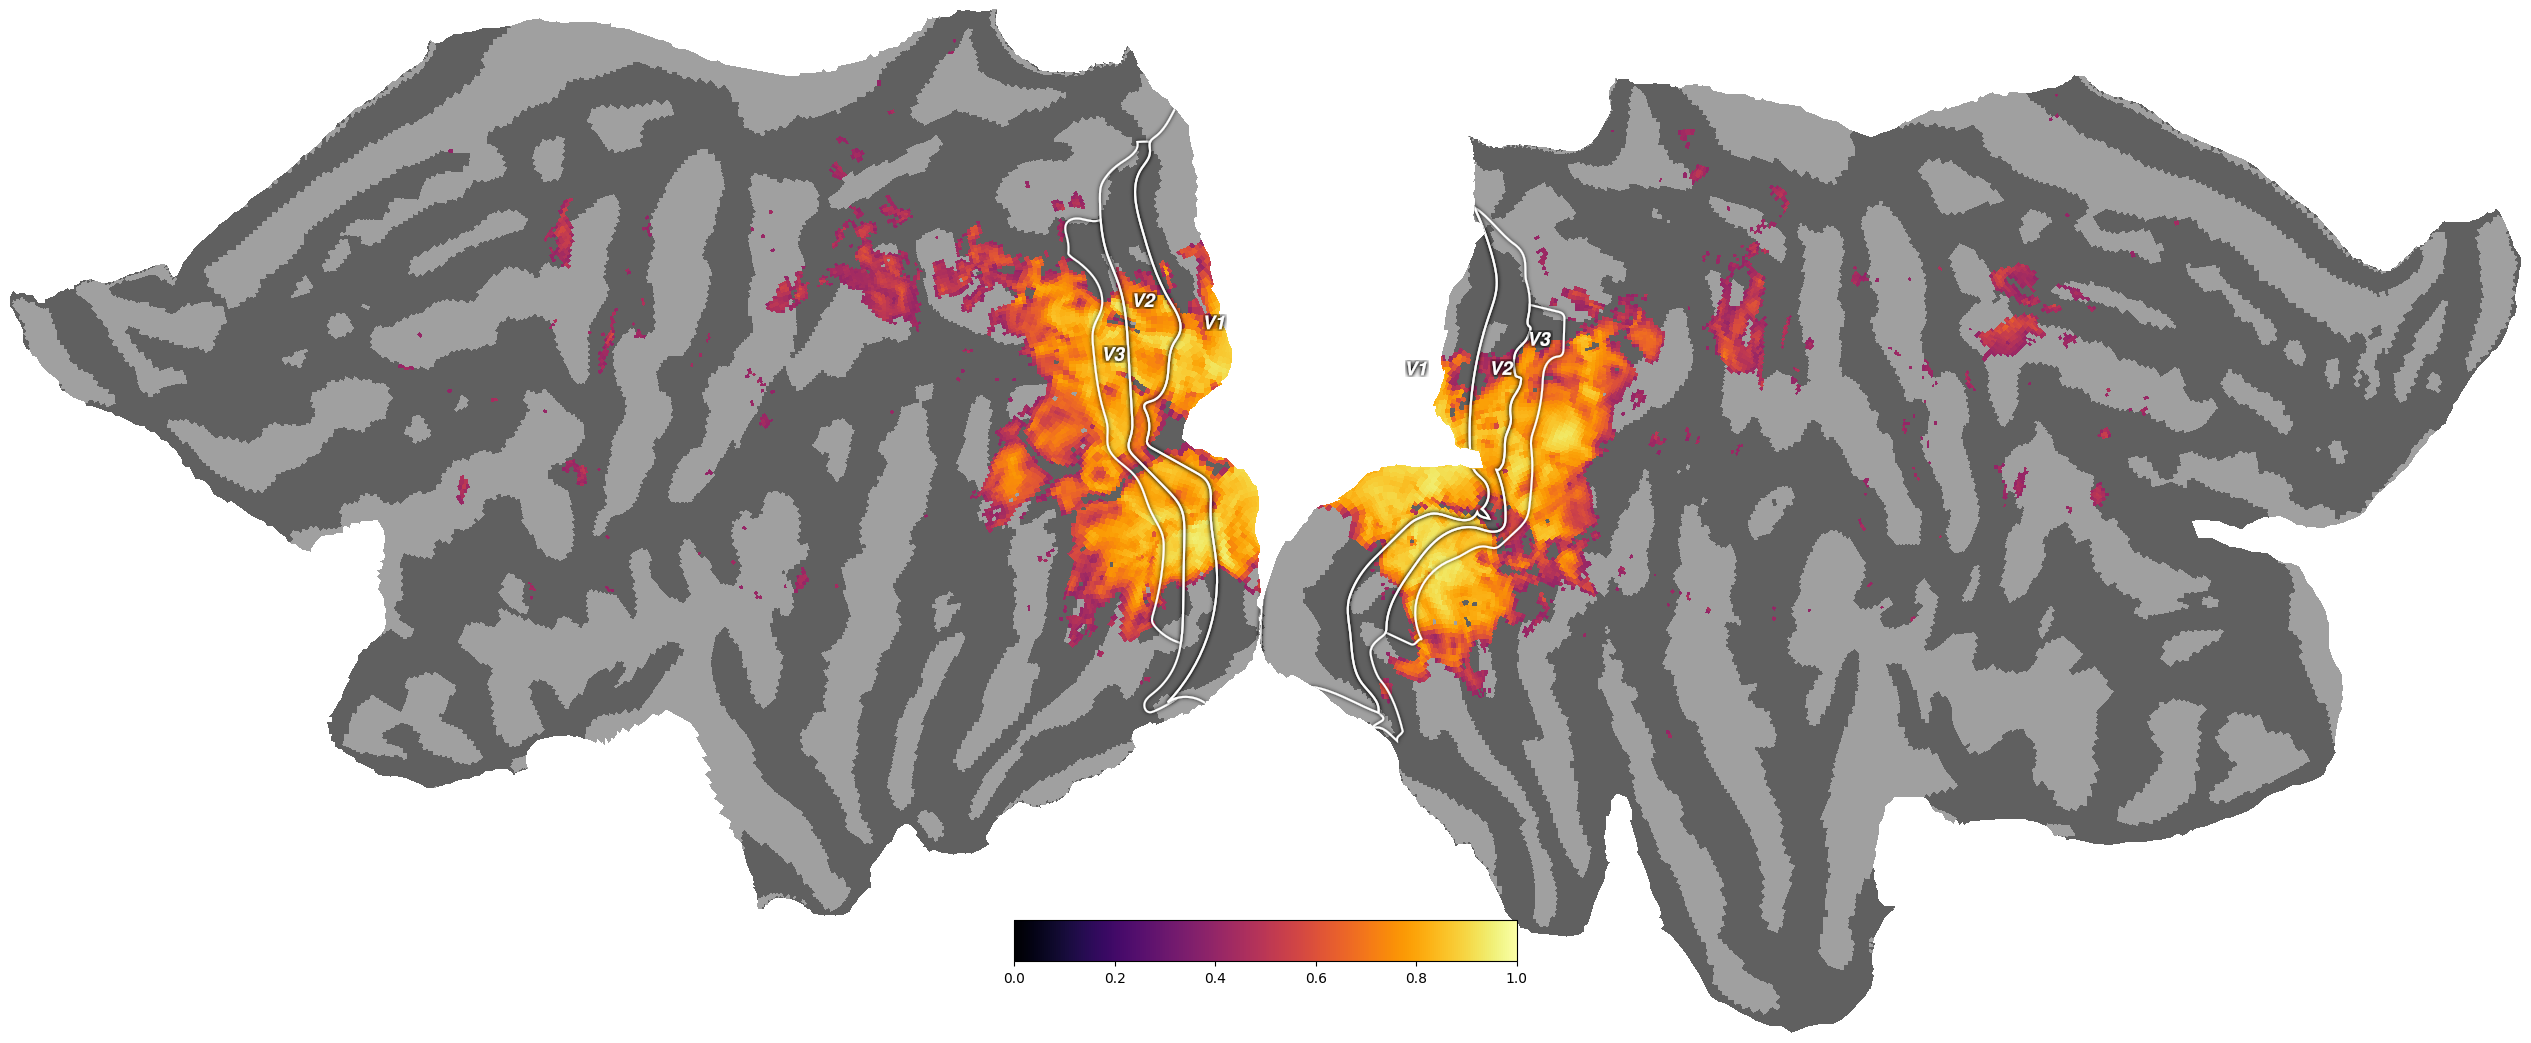

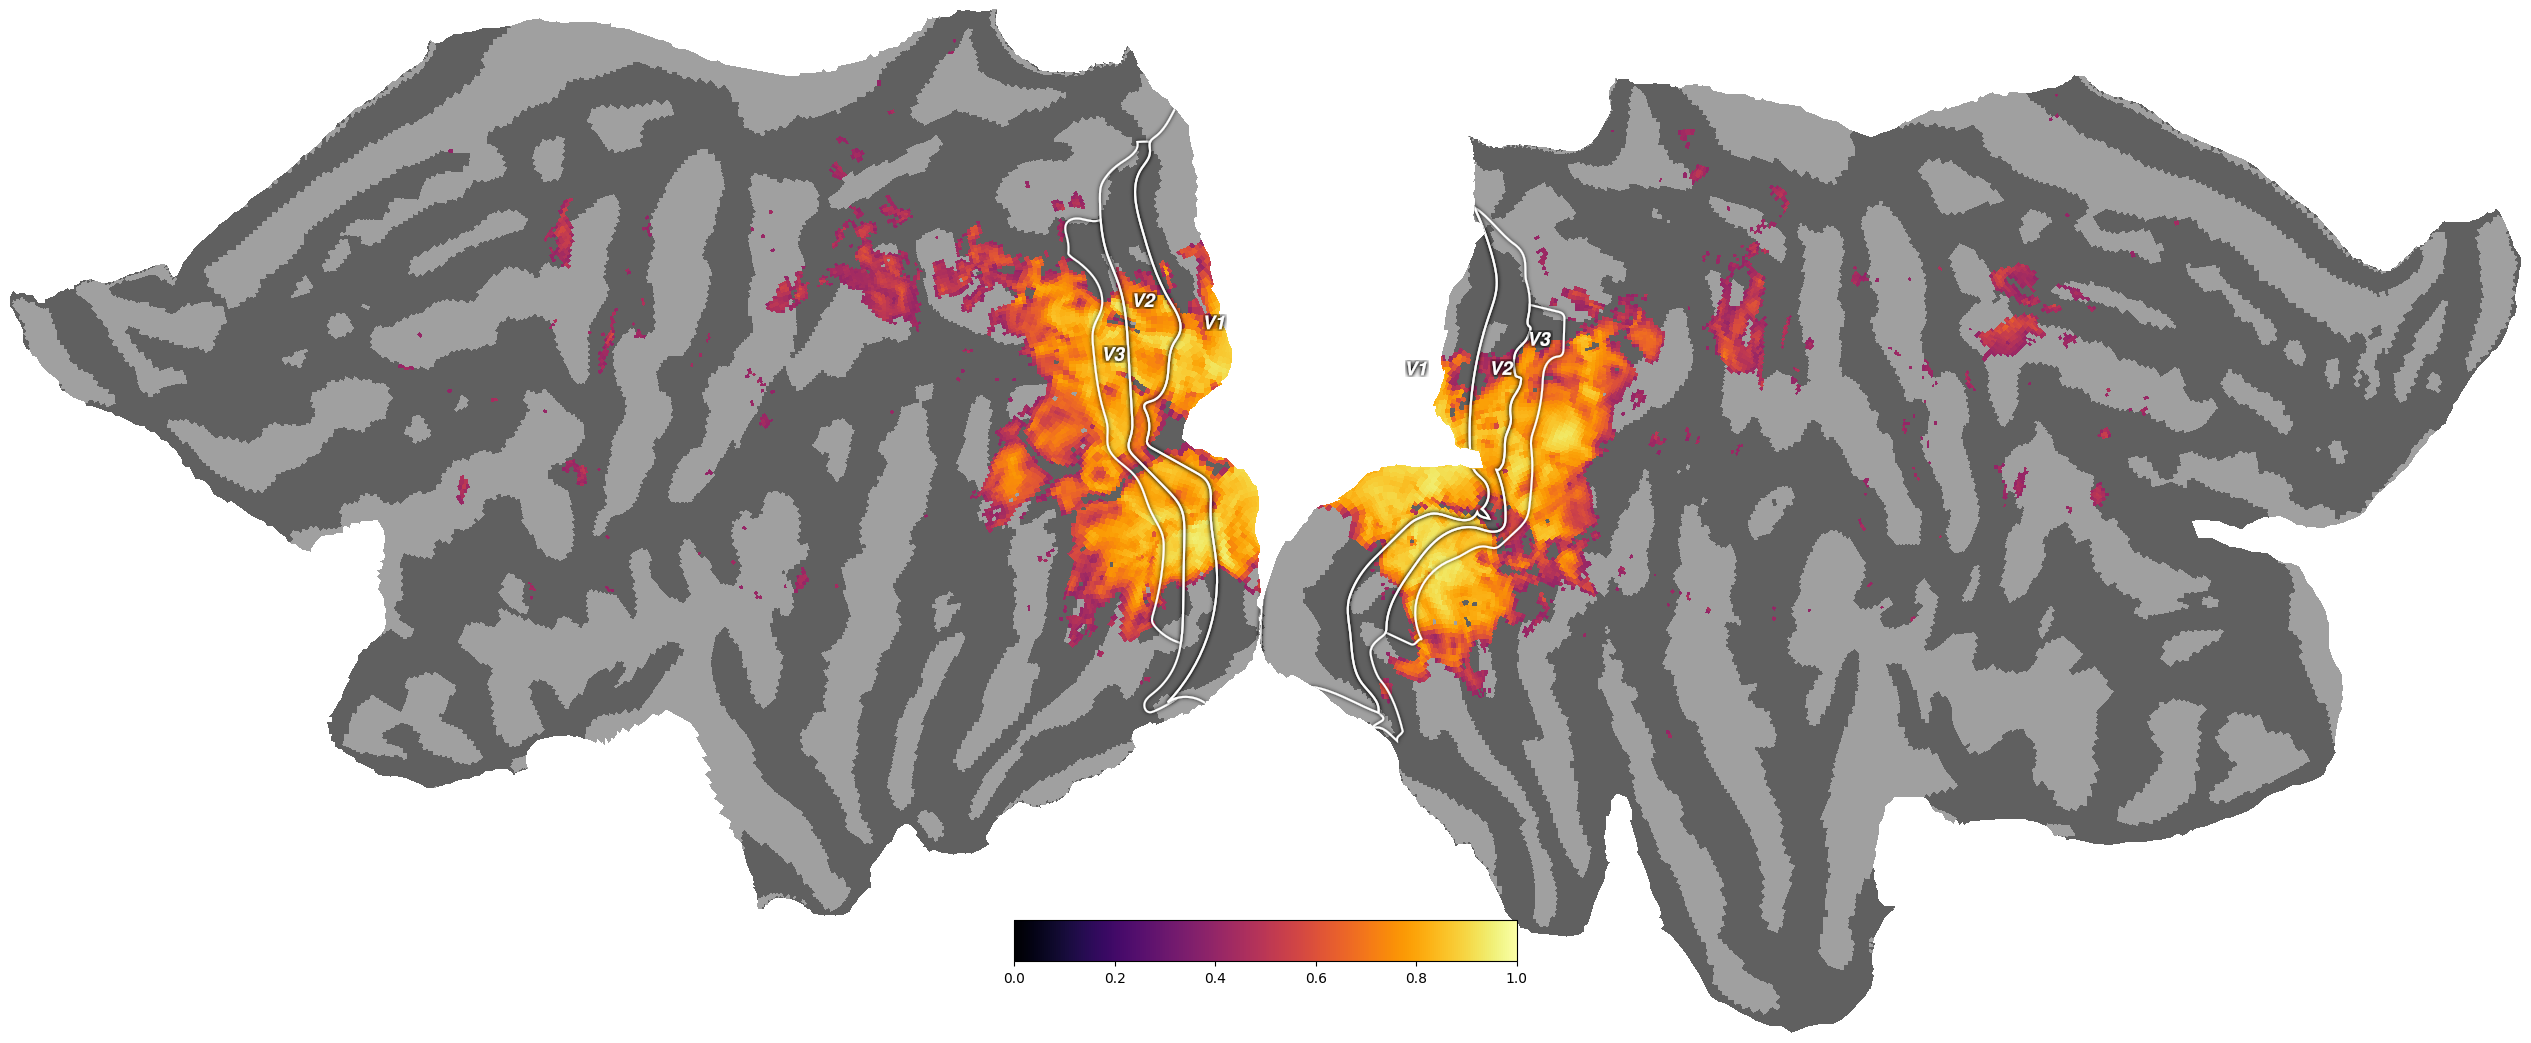

In [67]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[get_cortex(dnparams[:,-1]) > 0.4] = get_cortex(dnparams[:,-1])[get_cortex(dnparams[:,-1]) > 0.4]
rsq = np.copy(toplot)


cx.quickshow(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0, vmax=1), with_curvature=True)

In [23]:
from copy import deepcopy
webgl_data = {'s2_angle': get_blend(cx.Vertex(s2angle, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi, priority=1)),
              's2_ecc': get_blend(cx.Vertex(s2ecc, subject='hcp_999999', cmap='plasma', vmin=0, vmax=15, priority=2)),
              's2_rsq': get_blend(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0, vmax=1, priority=3))}

cx.webgl.show(webgl_data, port=8810);

Stopping server


In [31]:
cx.webgl.show(webgl_data, port=8810);

Started server on port 8810
Making HTTP connection to node230:88104H                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

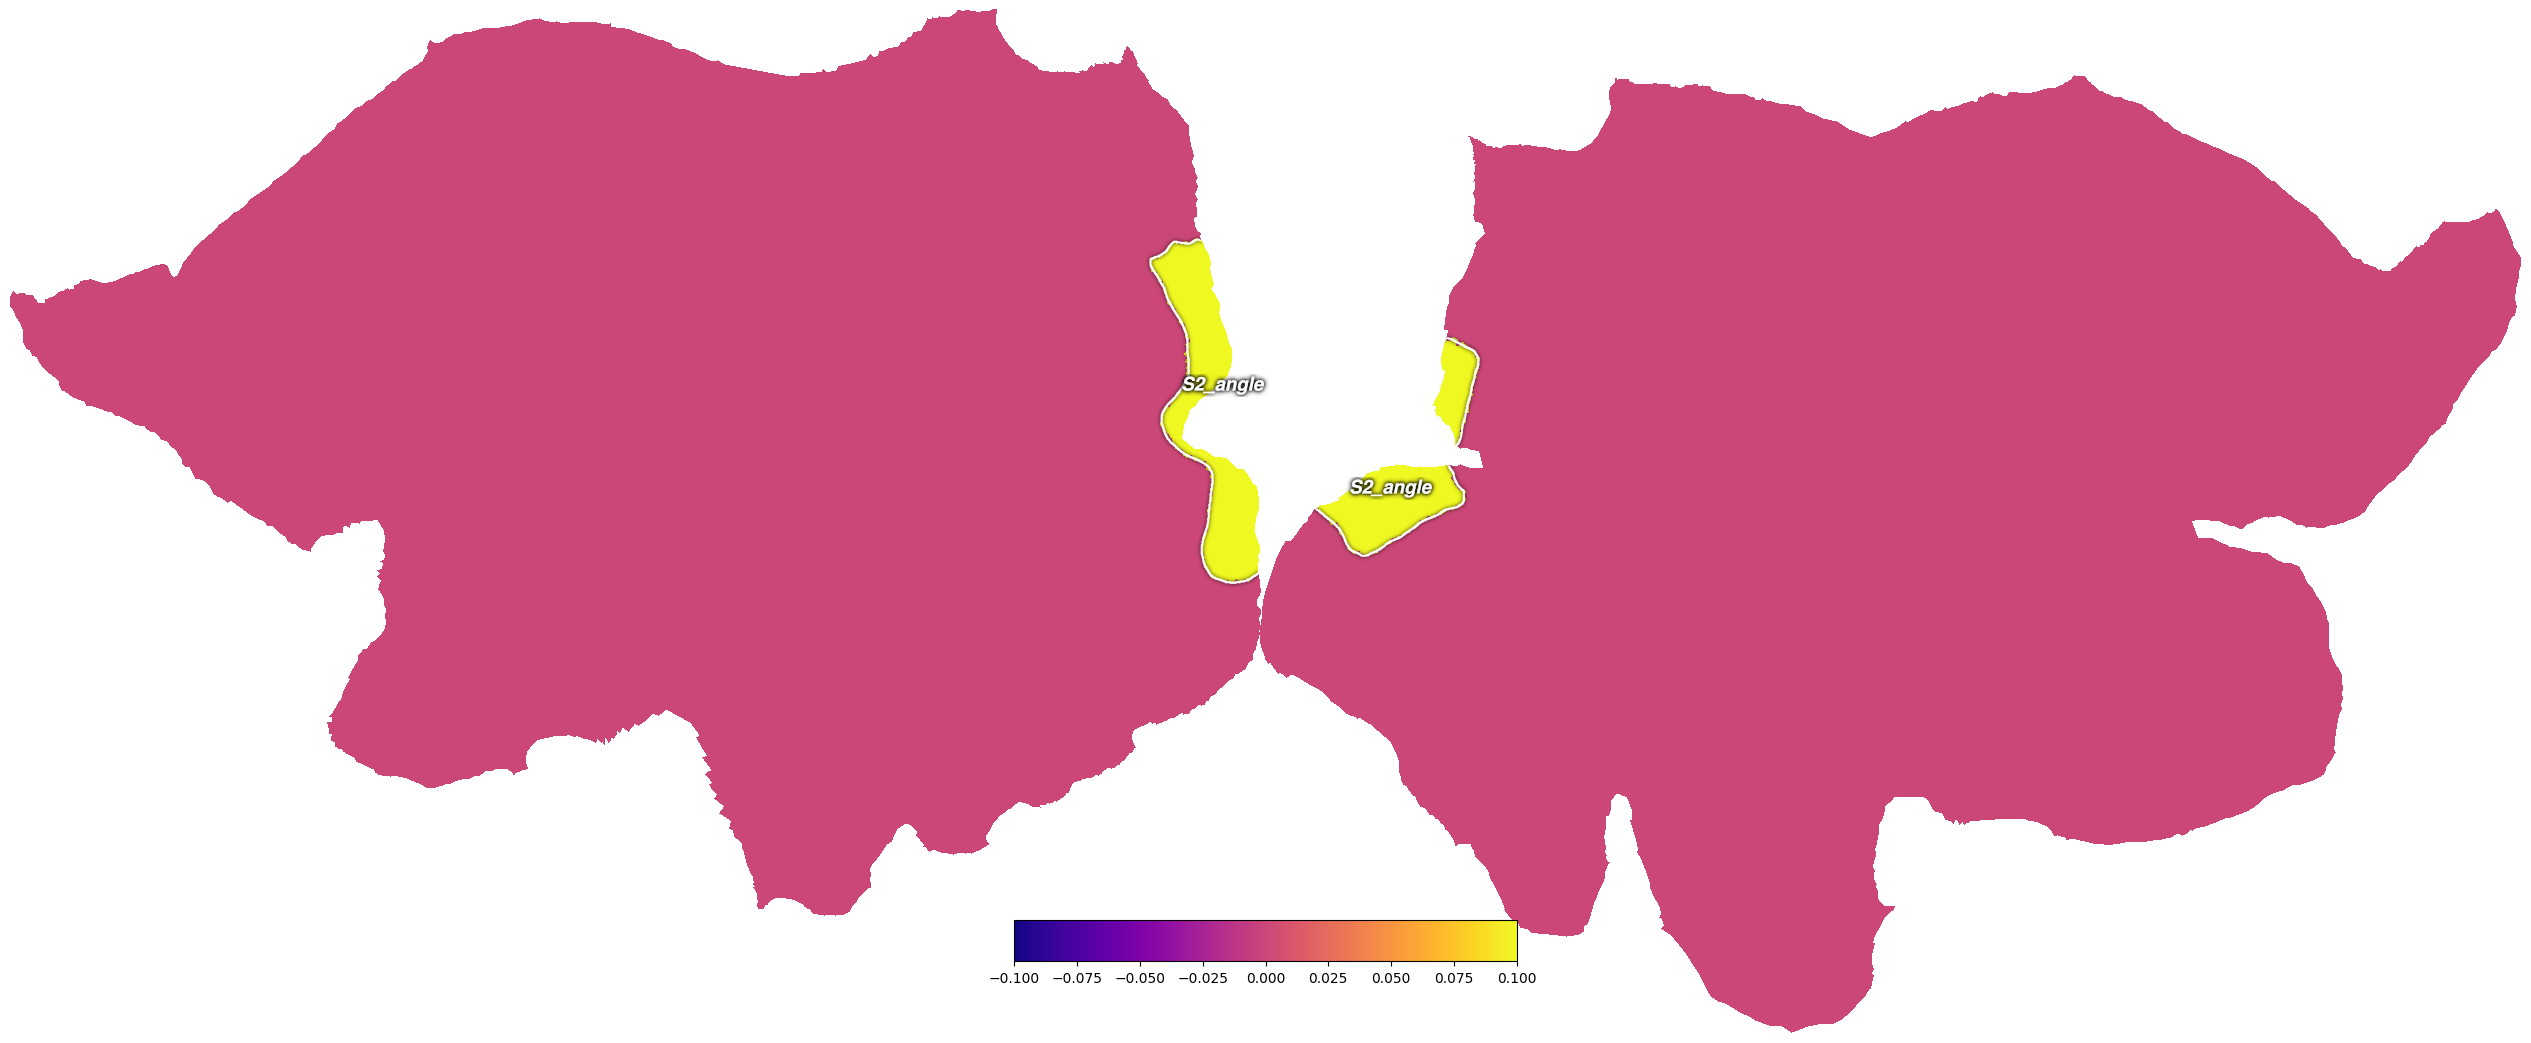

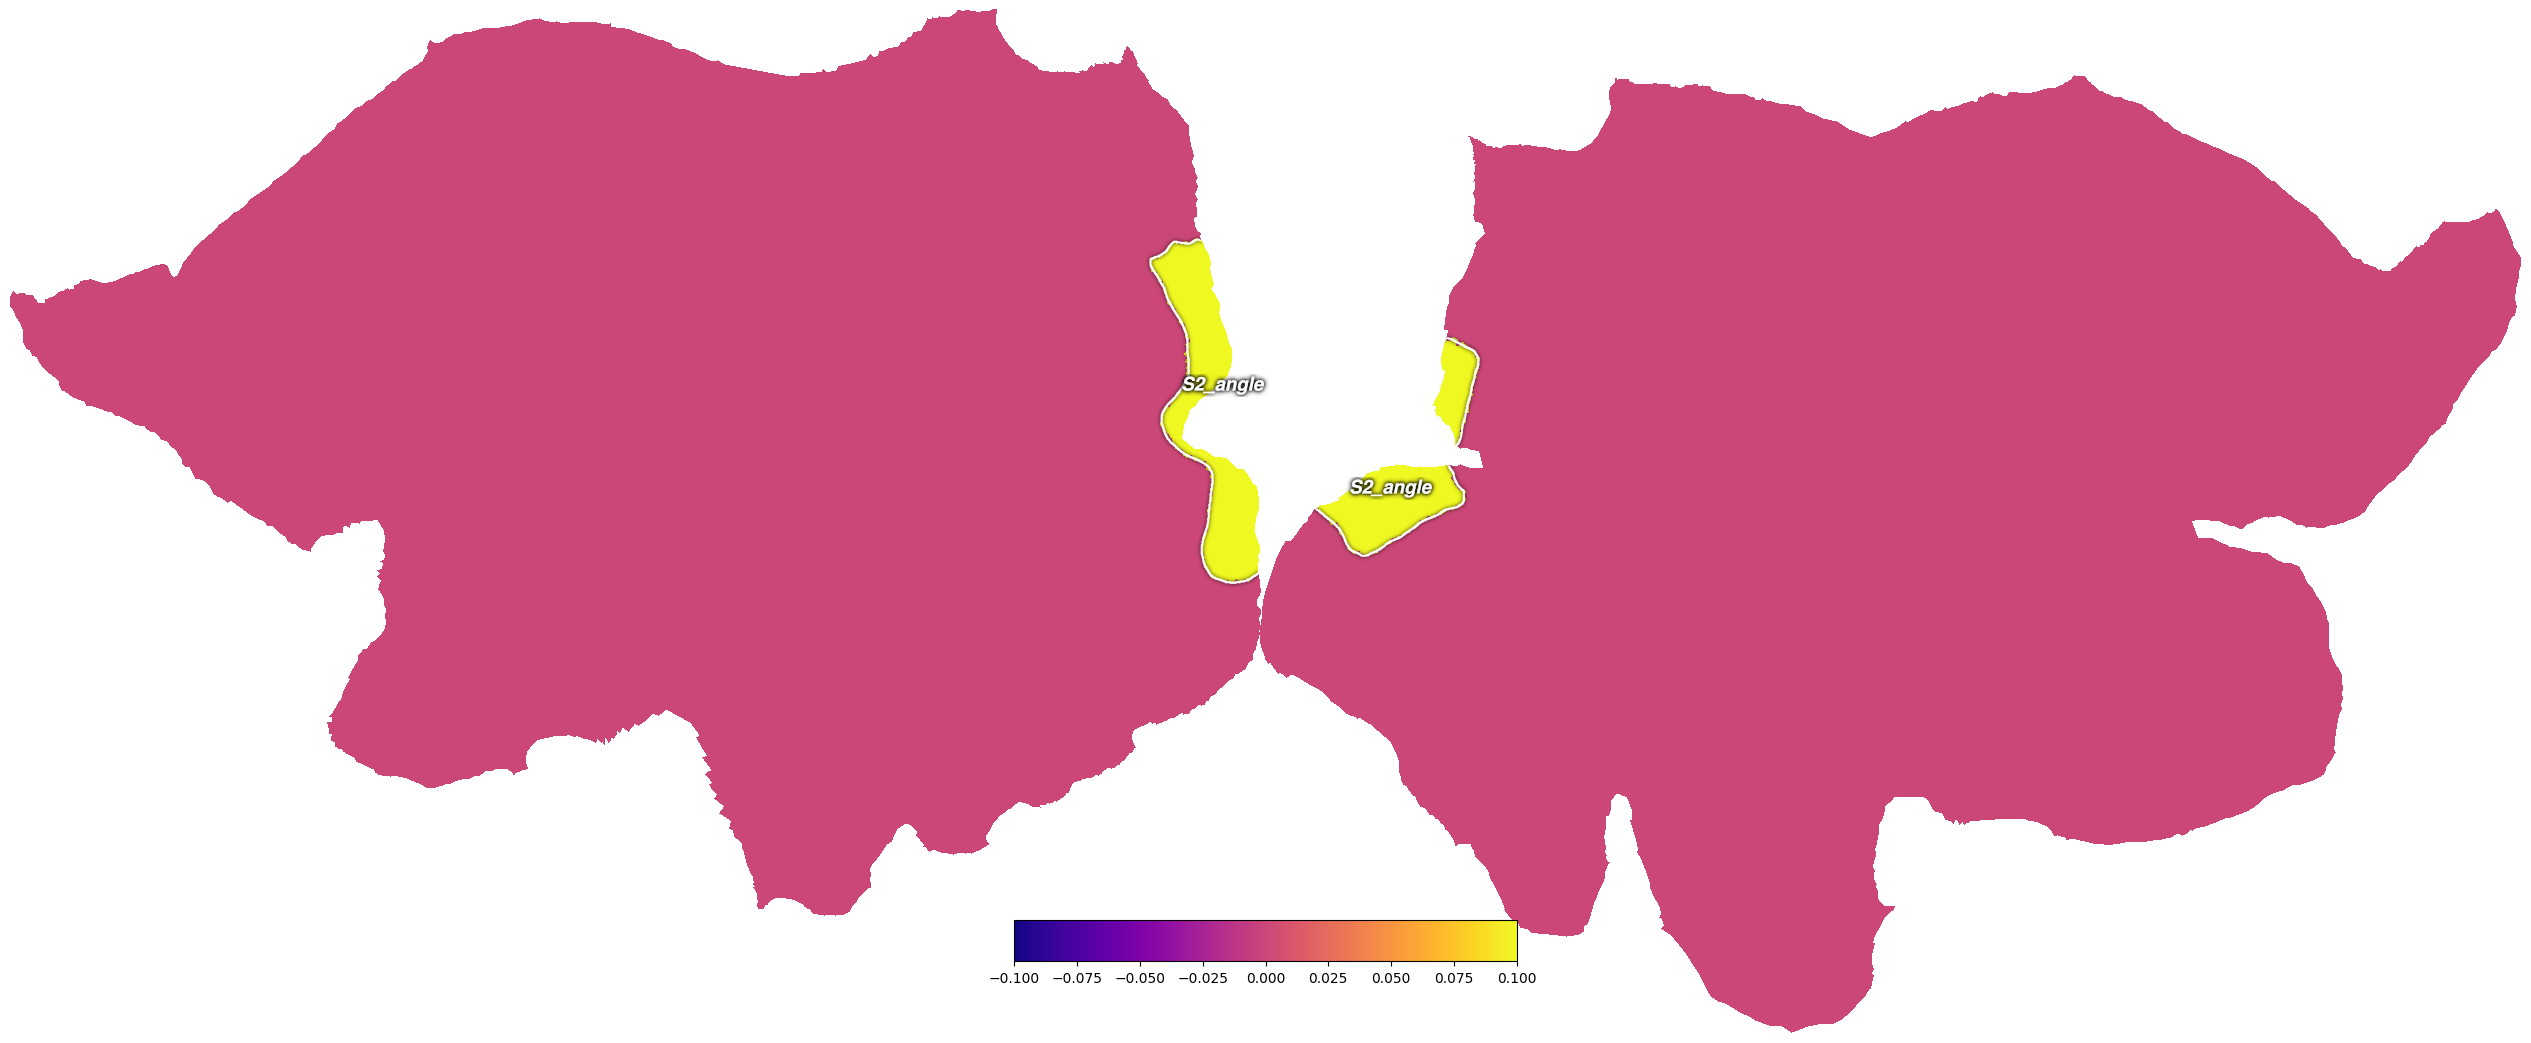

In [46]:
roi_verts = cx.get_roi_verts('hcp_999999', ['S2_angle'], mask=True)
# roi_verts['S2_angle']
dat = cx.Vertex(roi_verts['S2_angle'].astype(int), subject = 'hcp_999999', cmap='plasma')
cx.quickshow(dat)
# dat

In [21]:
for i in webgl_data:
    cx.utils.add_roi(webgl_data[f'{i}'], name=f'{i}')

In [30]:
cx.utils.add_roi(cx.Vertex(s2angle, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), name='S2_angle')

0

In [49]:
gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')

gf_P = Iso2DGaussianFitter(data=np.nan_to_num(get_cortex(s2_f)[V1_mask]), model=gg, n_jobs=30, fit_css=False)
gf_P.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes, 
                 n_batches=60,
                 pos_prfs_only=True)

NameError: name 's2_f' is not defined

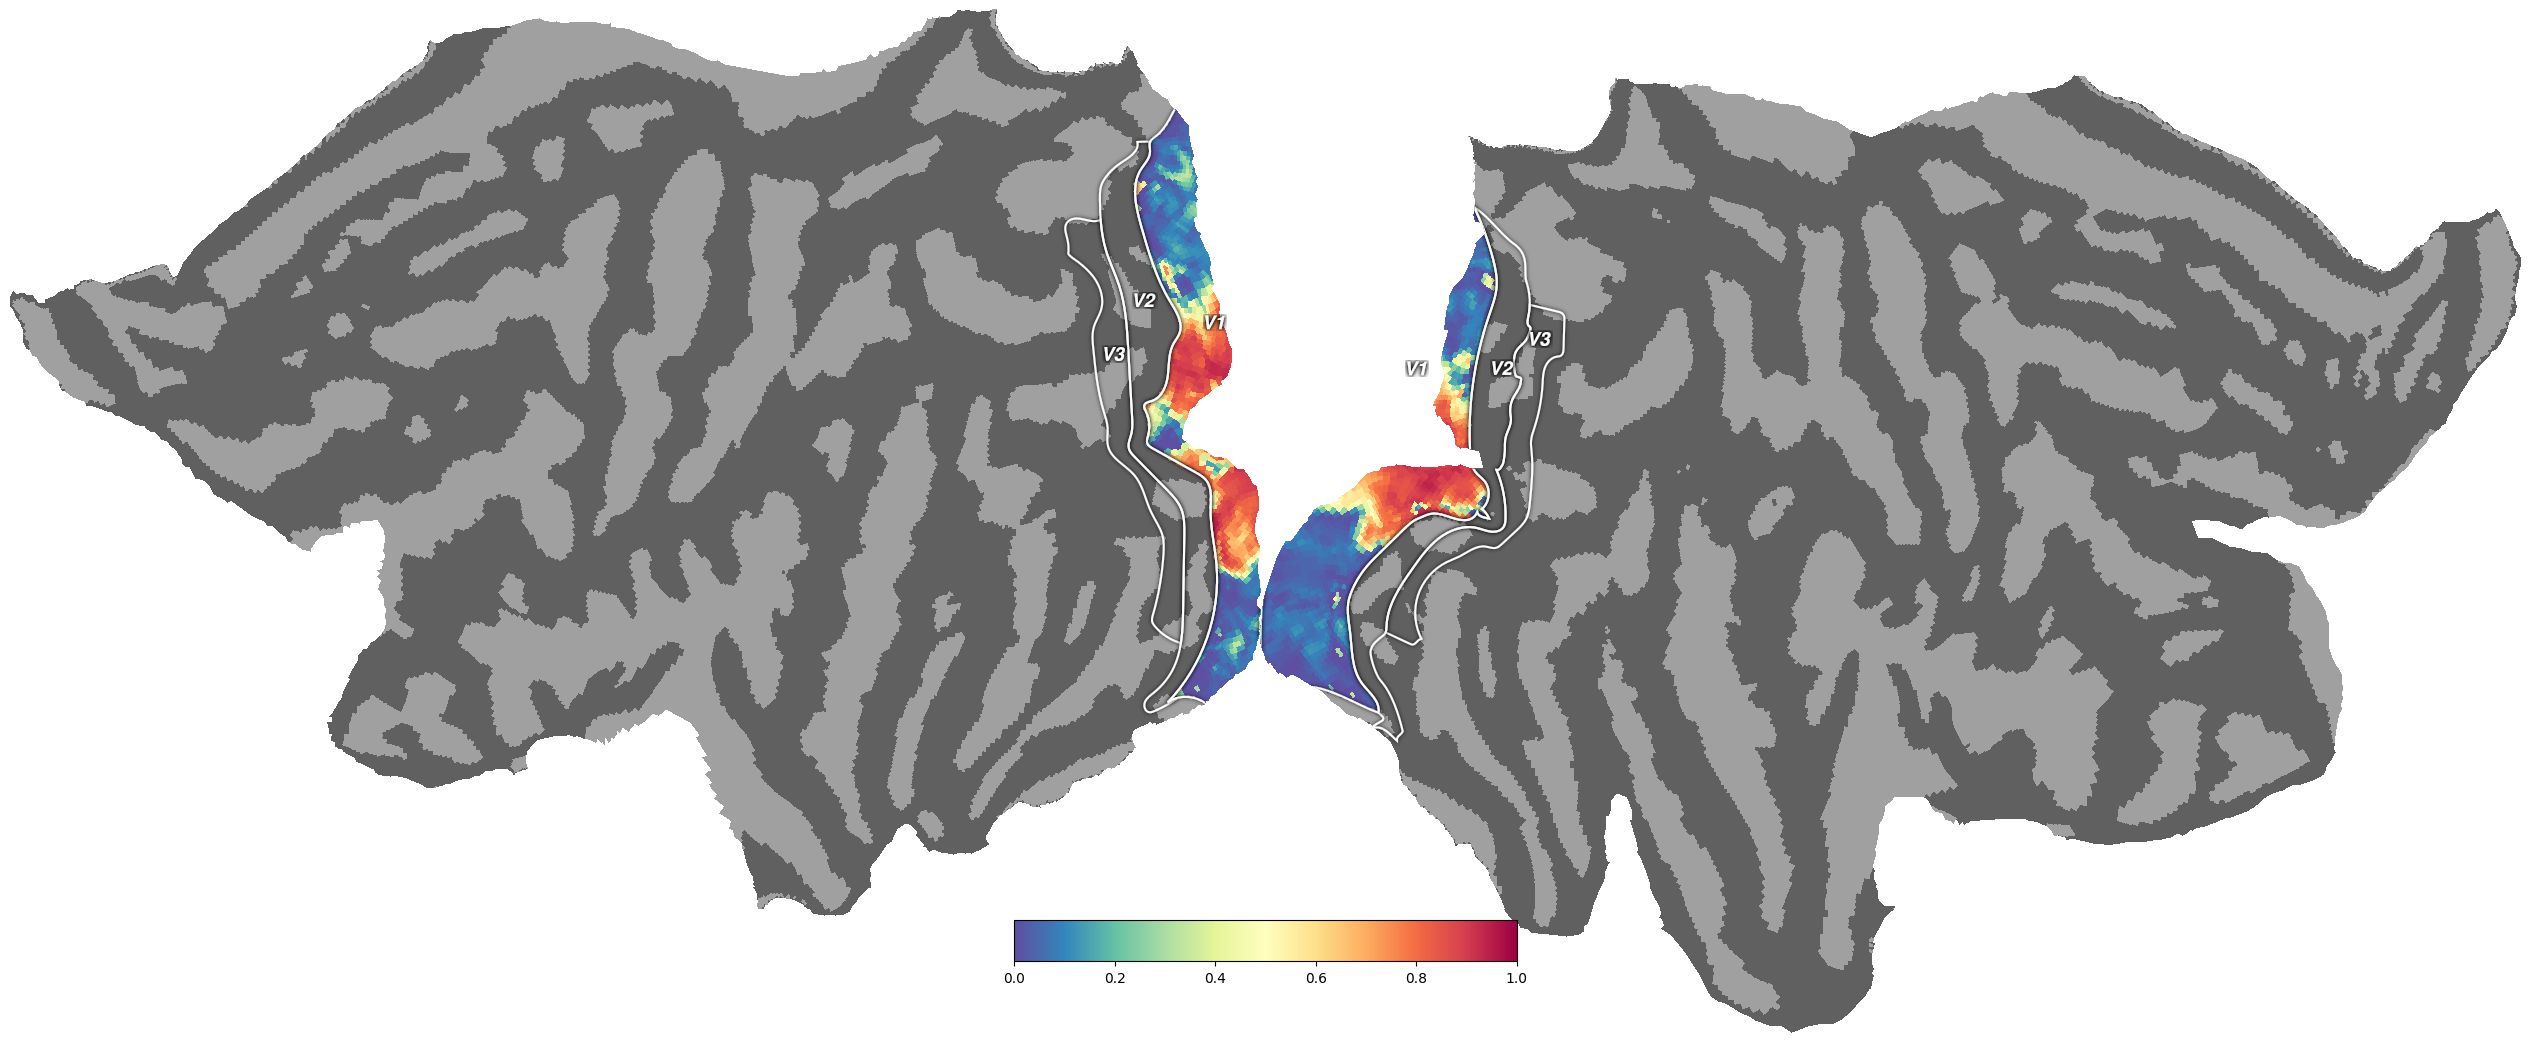

In [14]:
toplot=np.zeros(118584,)
toplot[:] = np.nan
toplot[V1_mask] = gf_P.gridsearch_params[:,-1]
# toplot[~V1_mask] = np.nan
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=0, vmax=1), with_curvature=True);

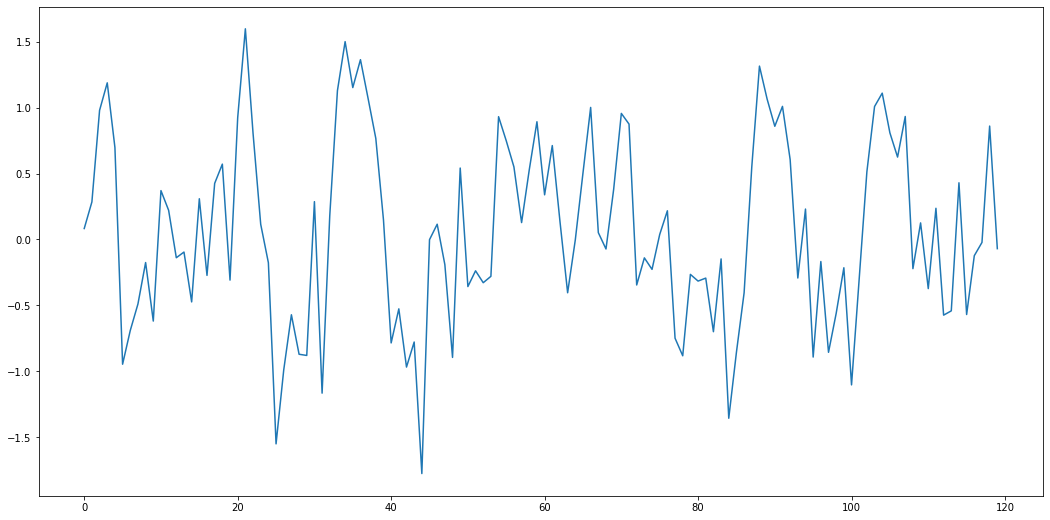

In [62]:
plt.figure(figsize=[18,9])
plt.plot(get_cortex(s2_f)[V1_mask][600,:].T)

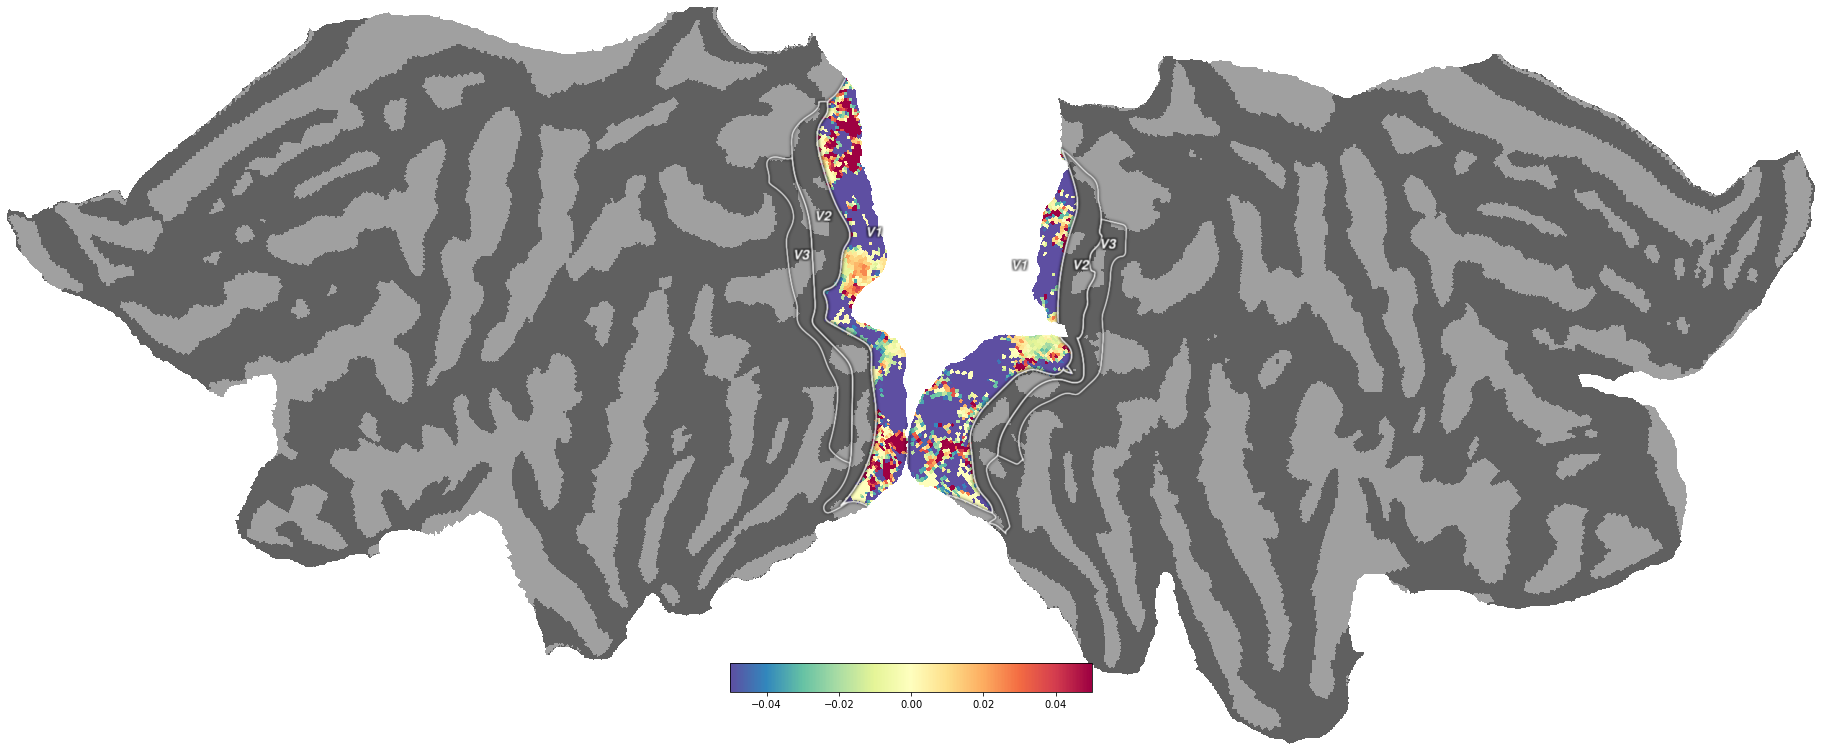

In [110]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[V1_mask] = gf_P.iterative_search_params[:,-1] - get_cortex(dnparams[:,-1])[V1_mask]

cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=-0.05, vmax=0.05), with_curvature=True);

In [1]:
allruns_s2 = np.load('/tank/klundert/projects/cfdn/notebooks/allruns_s2.npy')


NameError: name 'np' is not defined

In [ ]:
# use this one

allruns_s2 = np.load('/tank/klundert/projects/cfdn/notebooks/allruns_s2.npy')

# corlistbigs2 = [np.array(random.sample(mylist, 5))]

for i in range(np.shape(allruns_s2[::2])[0]):
# for i in range(3):
    
    
    corlistbigs2 = []
    i = 1+i
#     for j in range(np.shape(allruns_s2[::2])[0]-i):
    for j in range((np.shape(allruns_s2[::2])[0]+1)-i):
#     for j in range(6):
        avg_f1 = sum(np.nan_to_num(random.sample(allruns_s2[::2], i)))/len(random.sample(allruns_s2[::2], i))
        avg_f2 = sum(np.nan_to_num(random.sample(allruns_s2[1::2], i)))/len(random.sample(allruns_s2[1::2], i))
        
        df1 = pd.DataFrame(data=avg_f1)
        df2 = pd.DataFrame(data=avg_f2)
        cordf = df1.corrwith(df2, axis=1, method='pearson')
        corlistbigs2.append(cordf.values)
        
    cordic_s2["corr{0}".format(i)] = np.nanmean(corlistbigs2, axis=0)

In [30]:
tc_jur = np.load('/tank/klundert/projects/cfdn/tc.npy').T


In [89]:
gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')

gf_P = Iso2DGaussianFitter(data=tc_jur, model=gg, n_jobs=1, fit_css=False)
gf_P.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes, 
                 n_batches=60)

gf_P.iterative_fit(rsq_threshold=0.01, verbose=True, bounds=gauss_bounds, constraints=[])

gf_P.crossvalidate_fit(get_cortex(s2_f2)[V1_mask], single_hrf=False)

# np.save("/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/gaussian-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy", gf_P.iterative_search_params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':


Performing bounded, constrained minimization (trust-constr).


/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 213, function evaluations: 1386, CG iterations: 702, optimality: 5.58e-04, constraint violation: 0.00e+00, execution time: 1.4e+01 s.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s finished


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2890 but corresponding boolean dimension is 1

In [48]:
BFGS = np.copy(gf_P.iterative_search_params[:,-1])
# BFGS

NameError: name 'gf_P' is not defined

Text(0.5, 0.98, 'cv R2 difference bfgs - trustconstr')

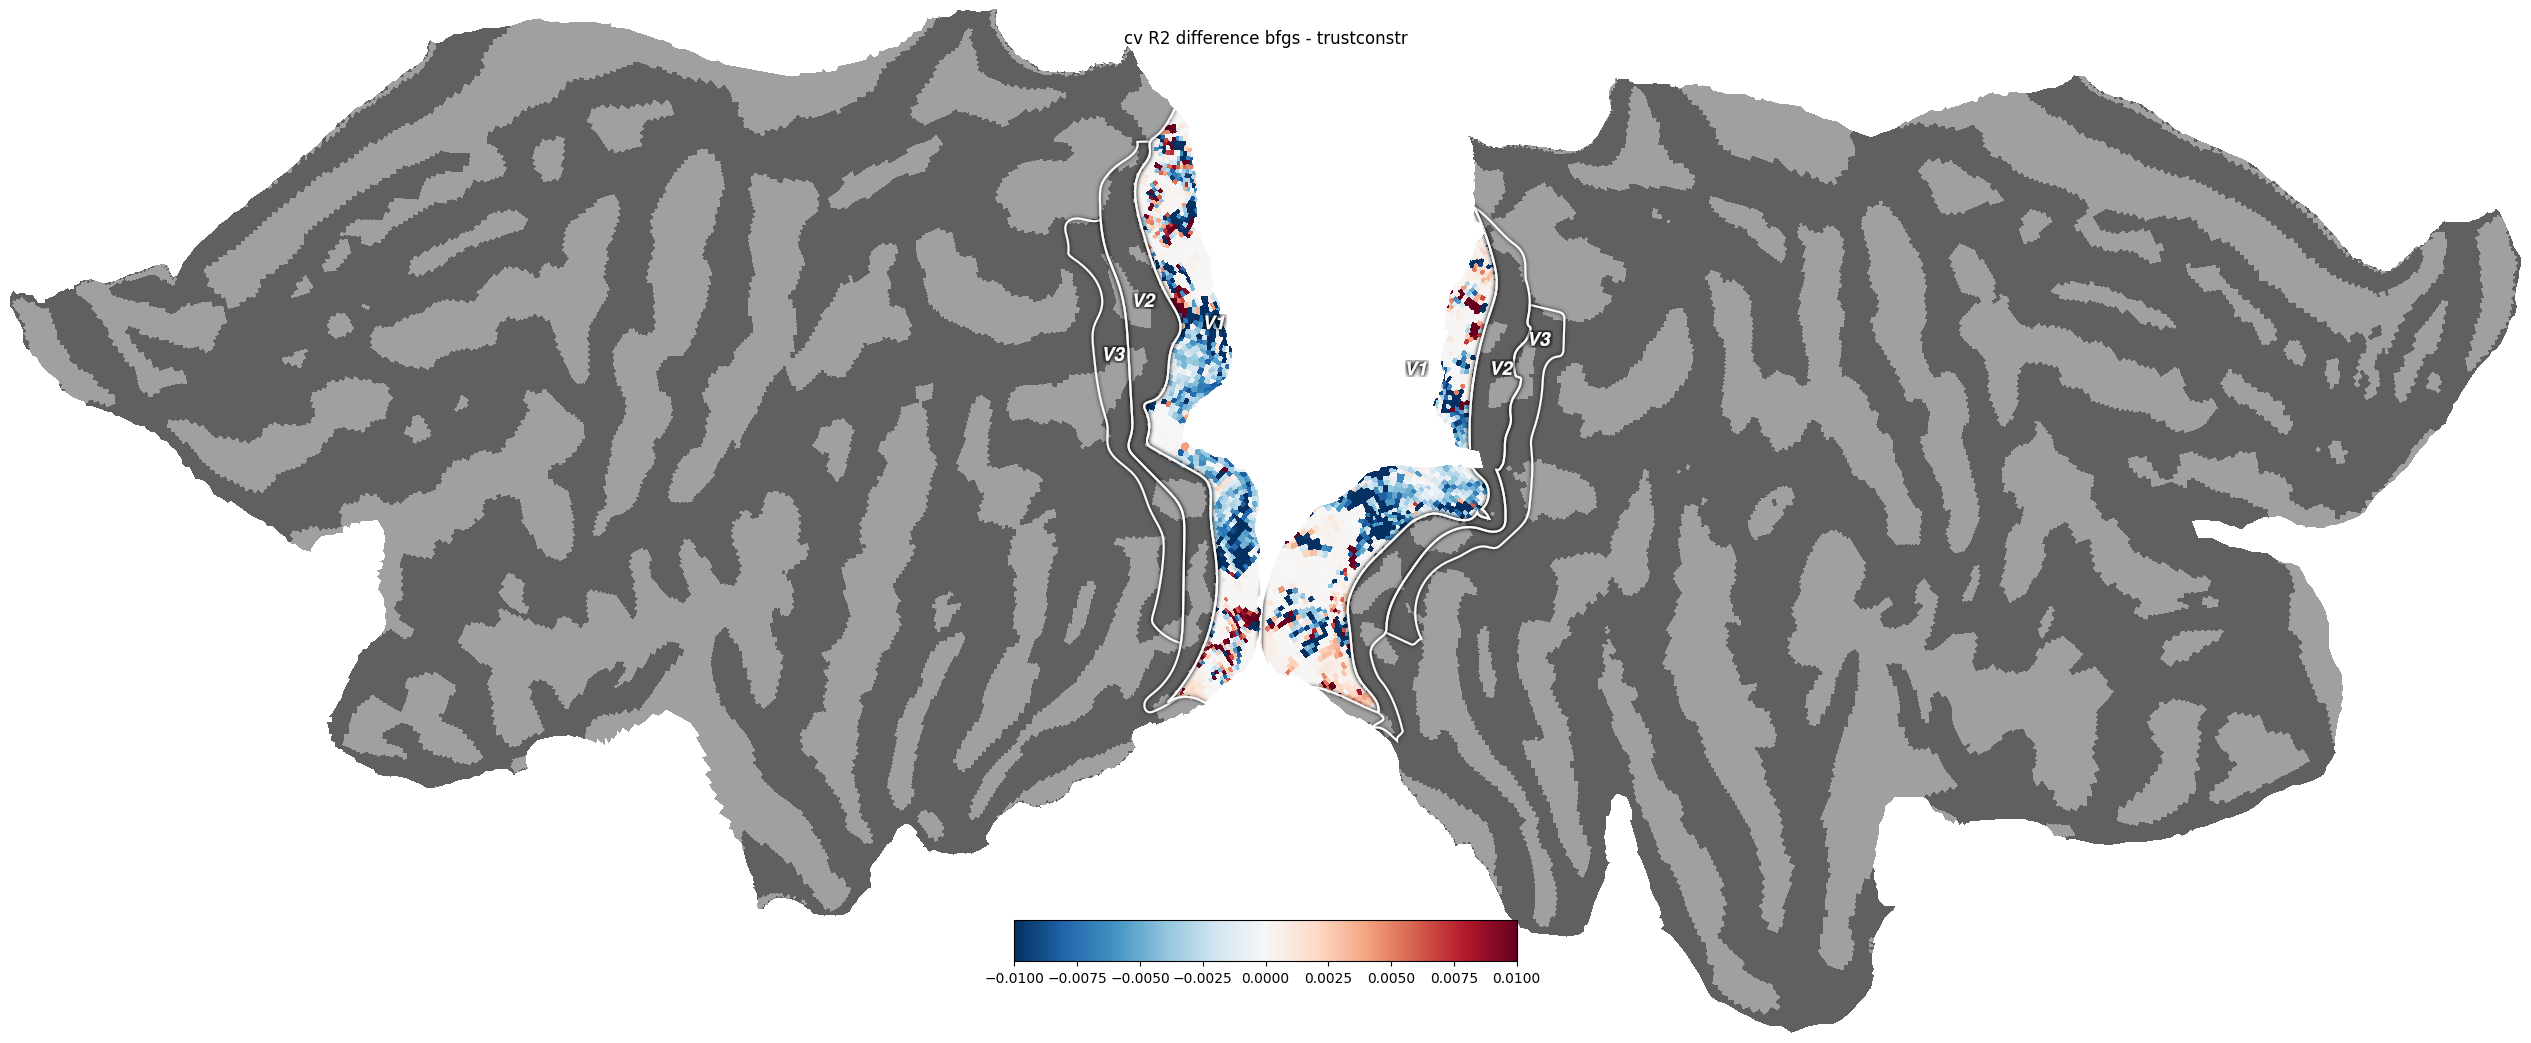

In [74]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[V1_mask] = BFGS - gf_P.iterative_search_params[:,-1]

f = cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', vmin=-0.01, vmax=0.01), with_curvature=True);

# zoom_to_roi('hcp_999999', 'V2', hem='')
f.suptitle('cv R2 difference bfgs - trustconstr')

In [47]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[V1_mask] = gf_P.iterative_search_params[:,-1]

f = cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True);


# zoom_to_roi('hcp_999999', 'V2', hem='')
f.suptitle('pRF size - BFGS')

NameError: name 'gf_P' is not defined

Text(0.5, 0.98, 'pRF size - trust-constr')

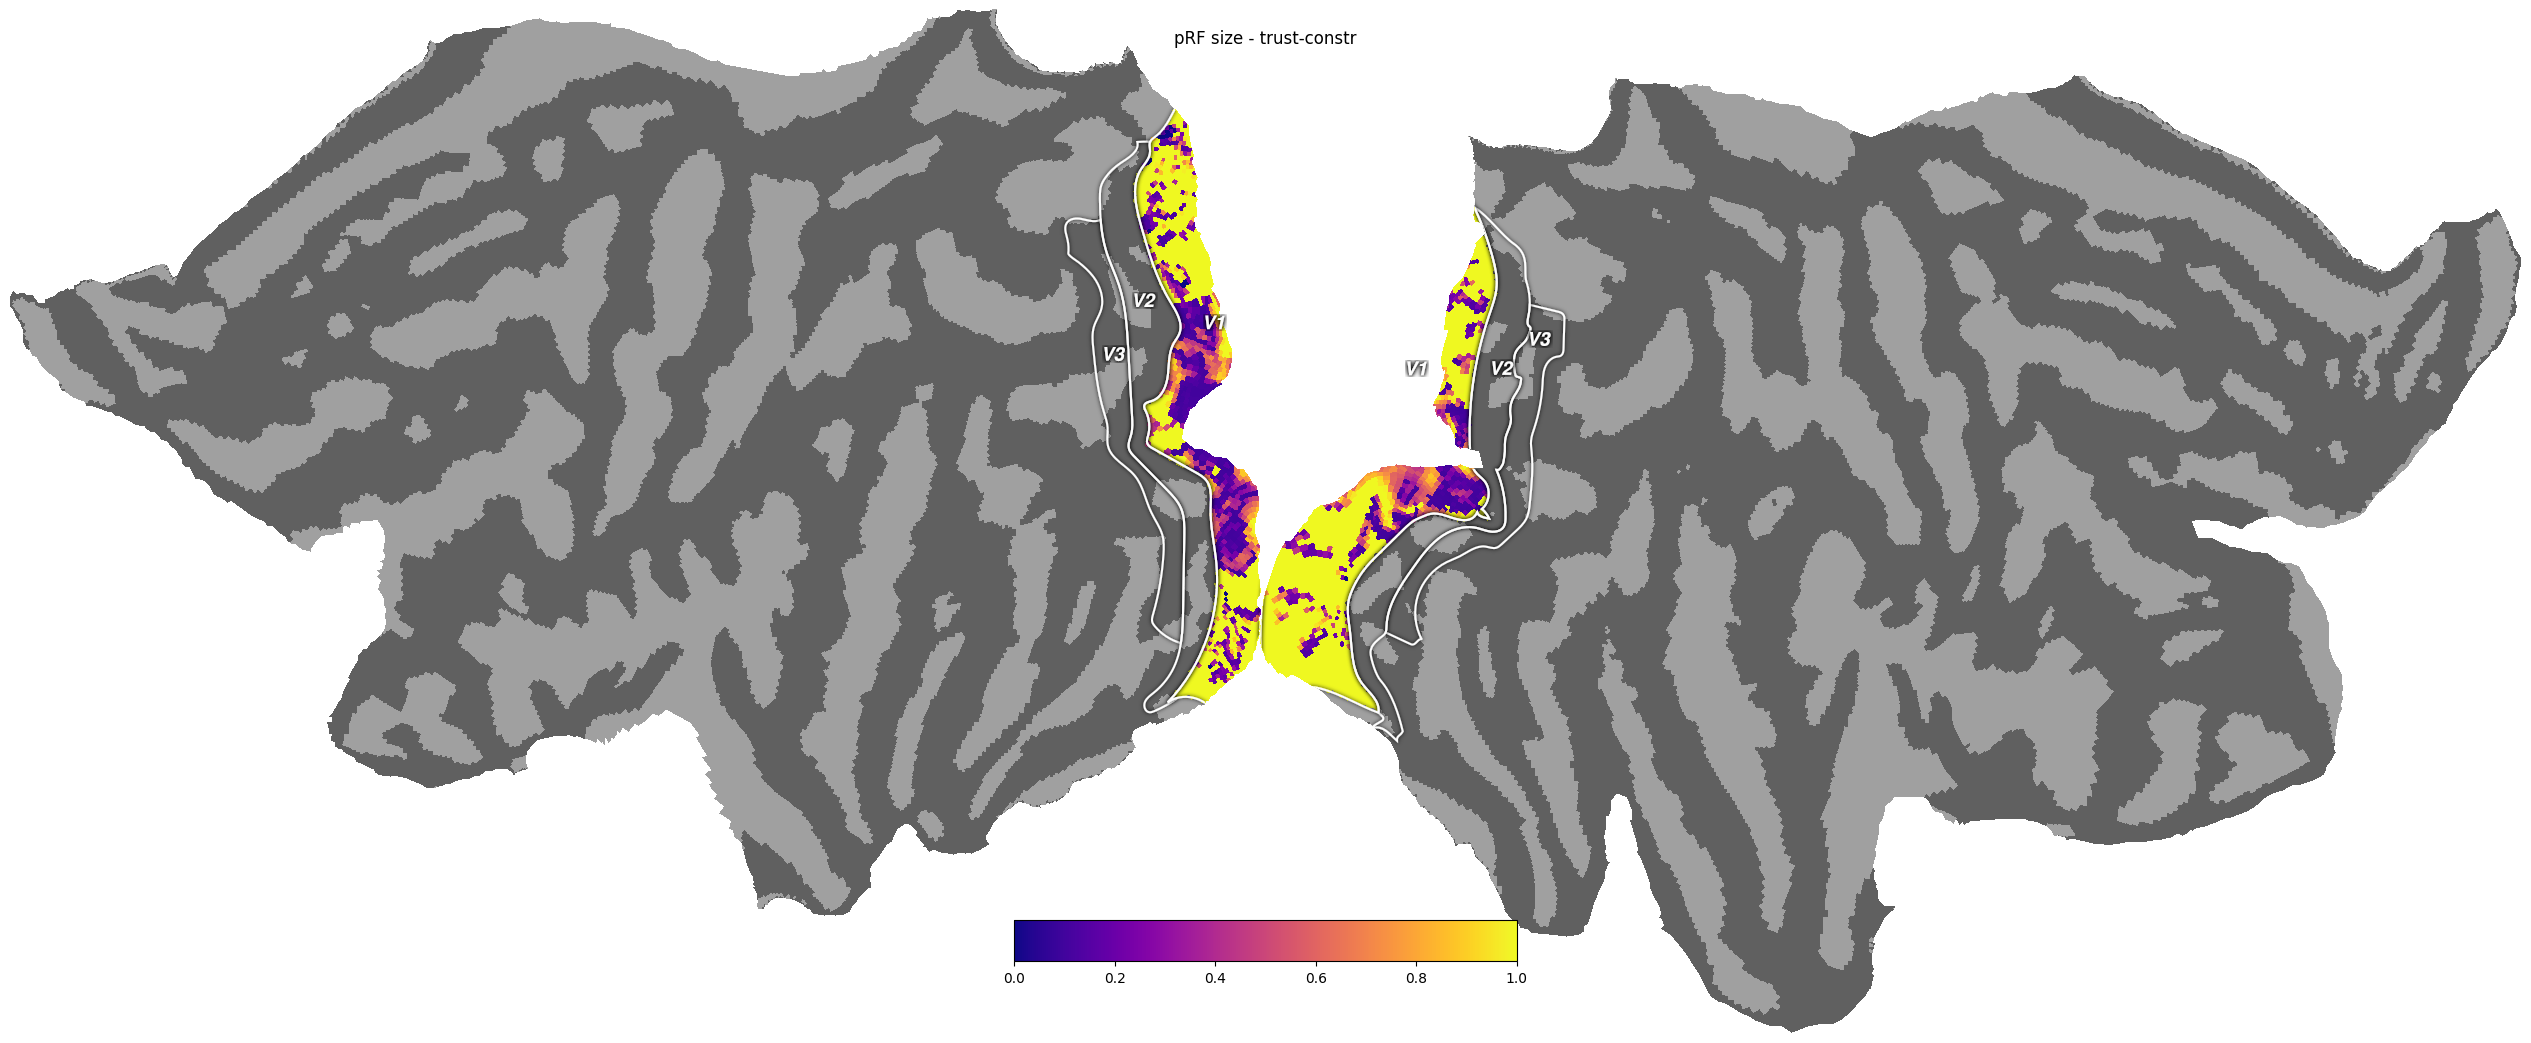

In [88]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[V1_mask] = gf_P.iterative_search_params[:,2]

f = cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True);


# zoom_to_roi('hcp_999999', 'V2', hem='')
f.suptitle('pRF size - trust-constr')

[ 2.15707984 -1.45733642  0.57104848  0.09115541  0.          0.59729398]


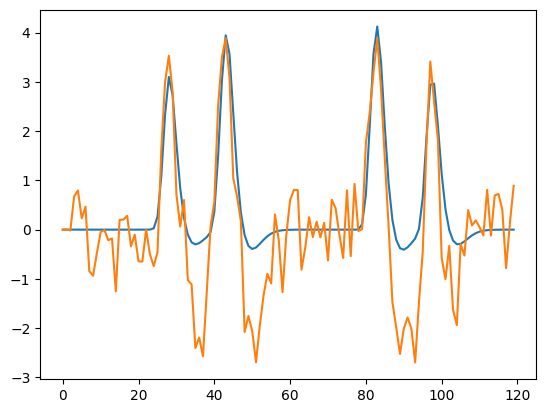

In [ ]:
print(gf_P.iterative_search_params[0])

plt.plot(gf_P.model.return_prediction(*gf_P.iterative_search_params[0][:-1]).T)
plt.plot(tc_jur.T)

[ 2.12149639 -1.55893342  0.10213184  2.74844868  0.          0.60650349]


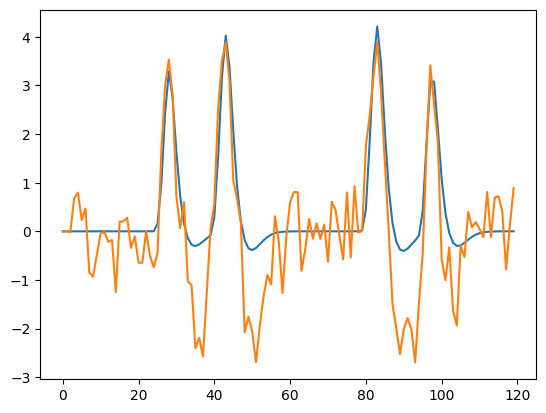

Performing bounded, constrained minimization (trust-constr).
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 72, CG iterations: 40, optimality: 6.80e-04, constraint violation: 0.00e+00, execution time: 0.18 s.
Performing bounded, constrained minimization (trust-constr).
`gtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 600, CG iterations: 265, optimality: 5.88e-04, constraint violation: 0.00e+00, execution time:  2.0 s.
Performing bounded, constrained minimization (trust-constr).
`gtol` termination condition is satisfied.
Number of iterations: 17, function evaluations: 90, CG iterations: 49, optimality: 2.24e-04, constraint violation: 0.00e+00, execution time:  0.3 s.
Performing bounded, constrained minimization (trust-constr).
`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 78, CG iterations: 43, optimality: 9.82e-04, constraint violation: 0.00e+00, execution

In [90]:
print(gf_P.iterative_search_params[0])

plt.plot(gf_P.model.return_prediction(*gf_P.iterative_search_params[0][:-1]).T)
plt.plot(tc_jur.T)

Text(0.5, 1.0, 'pRF size - trust_constr')

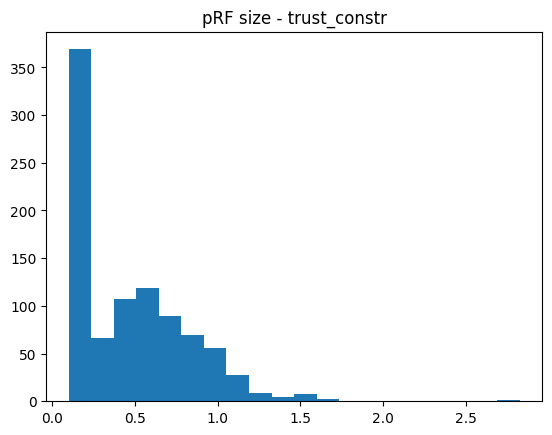

In [75]:
plt.hist(gf_P.iterative_search_params[:,2][gf_P.iterative_search_params[:,-1]>0.4], bins=20)
plt.title('pRF size - trust_constr')
# plt.hist(get_cortex(prfparams[:,2])[V1_mask][get_cortex(prfparams[:,-1]>0.4)[V1_mask]], bins=10, color='black')

Text(0.5, 1.0, 'pRF size - bfgs')

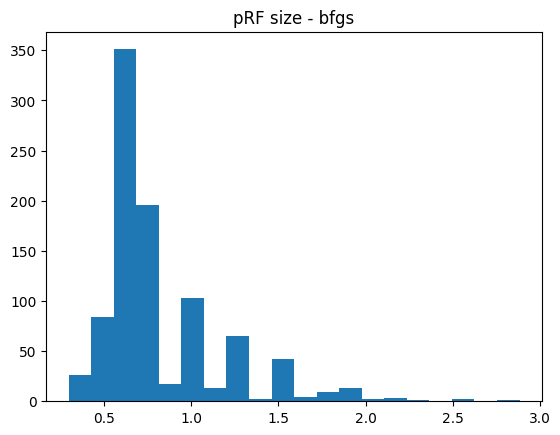


Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-

In [50]:
plt.hist(gf_P.iterative_search_params[:,2][gf_P.iterative_search_params[:,-1]>0.4], bins=20)
plt.title('pRF size - trust_constr')

# plt.hist(get_cortex(prfparams[:,2])[V1_mask][get_cortex(prfparams[:,-1]>0.4)[V1_mask]], bins=10, color='black')

In [46]:
gf_P.iterative_search_params[:,2]

array([0.55702719, 0.55702719, 0.55702719, ..., 0.55702719, 0.55702719,
       0.55702719])

In [15]:
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel, DoG_Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

In [29]:
gf_P.iterative_search_params = get_cortex(gf_P.iterative_search_params).shape

(118584, 6)

In [30]:
gg_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                    filter_predictions=False,
                                    filter_type='dc',
                                    )

gf_norm = Norm_Iso2DGaussianFitter(data=np.nan_to_num(s2_f),
                                   model=gg_norm,
                                   n_jobs=30,
                                   previous_gaussian_fitter=gf_P)

gf_norm.grid_fit(surround_amplitude_grid,
                         surround_size_grid,
                         neural_baseline_grid,
                         surround_baseline_grid,
                         verbose=True,
                         n_batches=60,
                         rsq_threshold=0.01,
                         pos_prfs_only=True)

gf_norm.iterative_fit(rsq_threshold=0.01, verbose=True, bounds=norm_bounds)

gf_norm.crossvalidate_fit(s2_f2,
                 single_hrf=False)

np.save("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy", gf_norm.iterative_search_params)

Each batch contains approx. 2050 voxels.


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed: 10.4min
[Parallel(n_jobs=30)]: Done   7 out of  60 | elapsed: 12.2min remaining: 92.4min
[Parallel(n_jobs=30)]: Done  13 out of  60 | elapsed: 14.6min remaining: 52.7min
[Parallel(n_jobs=30)]: Done  19 out of  60 | elapsed: 14.9min remaining: 32.1min
[Parallel(n_jobs=30)]: Done  25 out of  60 | elapsed: 18.3min remaining: 25.6min
[Parallel(n_jobs=30)]: Done  31 out of  60 | elapsed: 21.4min remaining: 20.0min
[Parallel(n_jobs=30)]: Done  37 out of  60 | elapsed: 24.0min remaining: 14.9min
[Parallel(n_jobs=30)]: Done  43 out of  60 | elapsed: 27.4min remaining: 10.8min
[Parallel(n_jobs=30)]: Done  49 out of  60 | elapsed: 27.6min remaining:  6.2min
[Parallel(n_jobs=30)]: Done  55 out of  60 | elapsed: 29.7min remaining:  2.7min
[Parallel(n_jobs=30)]: Done  60 out of  60 | elapsed: 30.3min finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 conc